# Task 5D

| | |
|---|---|
| Name | Bandi Krishna Chaitanya |
| Deakin ID | s225170881 |
| Submission Date | 2 August 2025 |

## Introduction

Data from https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction is used for this task. The dataset contains information about various properties in Paris, including their prices, locations, and other features. The goal is to predict the price of a property based on its features.

## Imports

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import shap
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Data Exploration

### Basic Information about the Dataset

In [2]:
# load the dataset
paris_real_estate_df = pd.read_csv('ParisHousing.csv')

In [3]:
# shape of the dataset
print(f"Shape of the dataset: {paris_real_estate_df.shape}")

Shape of the dataset: (10000, 17)


In [4]:
# print all features and their data types using tabulate
print(tabulate(paris_real_estate_df.dtypes.reset_index(), headers=['Feature', 'Data Type'], tablefmt='grid'))

+----+-------------------+-------------+
|    | Feature           | Data Type   |
+====+===================+=============+
|  0 | squareMeters      | int64       |
+----+-------------------+-------------+
|  1 | numberOfRooms     | int64       |
+----+-------------------+-------------+
|  2 | hasYard           | int64       |
+----+-------------------+-------------+
|  3 | hasPool           | int64       |
+----+-------------------+-------------+
|  4 | floors            | int64       |
+----+-------------------+-------------+
|  5 | cityCode          | int64       |
+----+-------------------+-------------+
|  6 | cityPartRange     | int64       |
+----+-------------------+-------------+
|  7 | numPrevOwners     | int64       |
+----+-------------------+-------------+
|  8 | made              | int64       |
+----+-------------------+-------------+
|  9 | isNewBuilt        | int64       |
+----+-------------------+-------------+
| 10 | hasStormProtector | int64       |
+----+----------

All the 17 features in the dataset are numerical. The dataset contains 10,000 rows and 17 columns. 

There may be some features that are recognized as numerical but are actually categorical. For example, as can be seen from the list of features above, `hasYard`, `hasPool` etc., are binary features that indicate whether a property has a yard, pool, etc. These features should be treated as categorical features rather than numerical features.

We shall explore the dataset to identify such features and treat them accordingly.

Target feature is `price` and the rest are input features.

### Check for Missing Values

In [5]:
# print the number of missing values in each feature using tabulate
missing_values = paris_real_estate_df.isnull().sum().reset_index()
missing_values.columns = ['Feature', 'Missing Values']
print(tabulate(missing_values, headers='keys', tablefmt='grid'))    

+----+-------------------+------------------+
|    | Feature           |   Missing Values |
+====+===================+==================+
|  0 | squareMeters      |                0 |
+----+-------------------+------------------+
|  1 | numberOfRooms     |                0 |
+----+-------------------+------------------+
|  2 | hasYard           |                0 |
+----+-------------------+------------------+
|  3 | hasPool           |                0 |
+----+-------------------+------------------+
|  4 | floors            |                0 |
+----+-------------------+------------------+
|  5 | cityCode          |                0 |
+----+-------------------+------------------+
|  6 | cityPartRange     |                0 |
+----+-------------------+------------------+
|  7 | numPrevOwners     |                0 |
+----+-------------------+------------------+
|  8 | made              |                0 |
+----+-------------------+------------------+
|  9 | isNewBuilt        |        

The dataset does not contain any missing values.

### Univariate Analysis

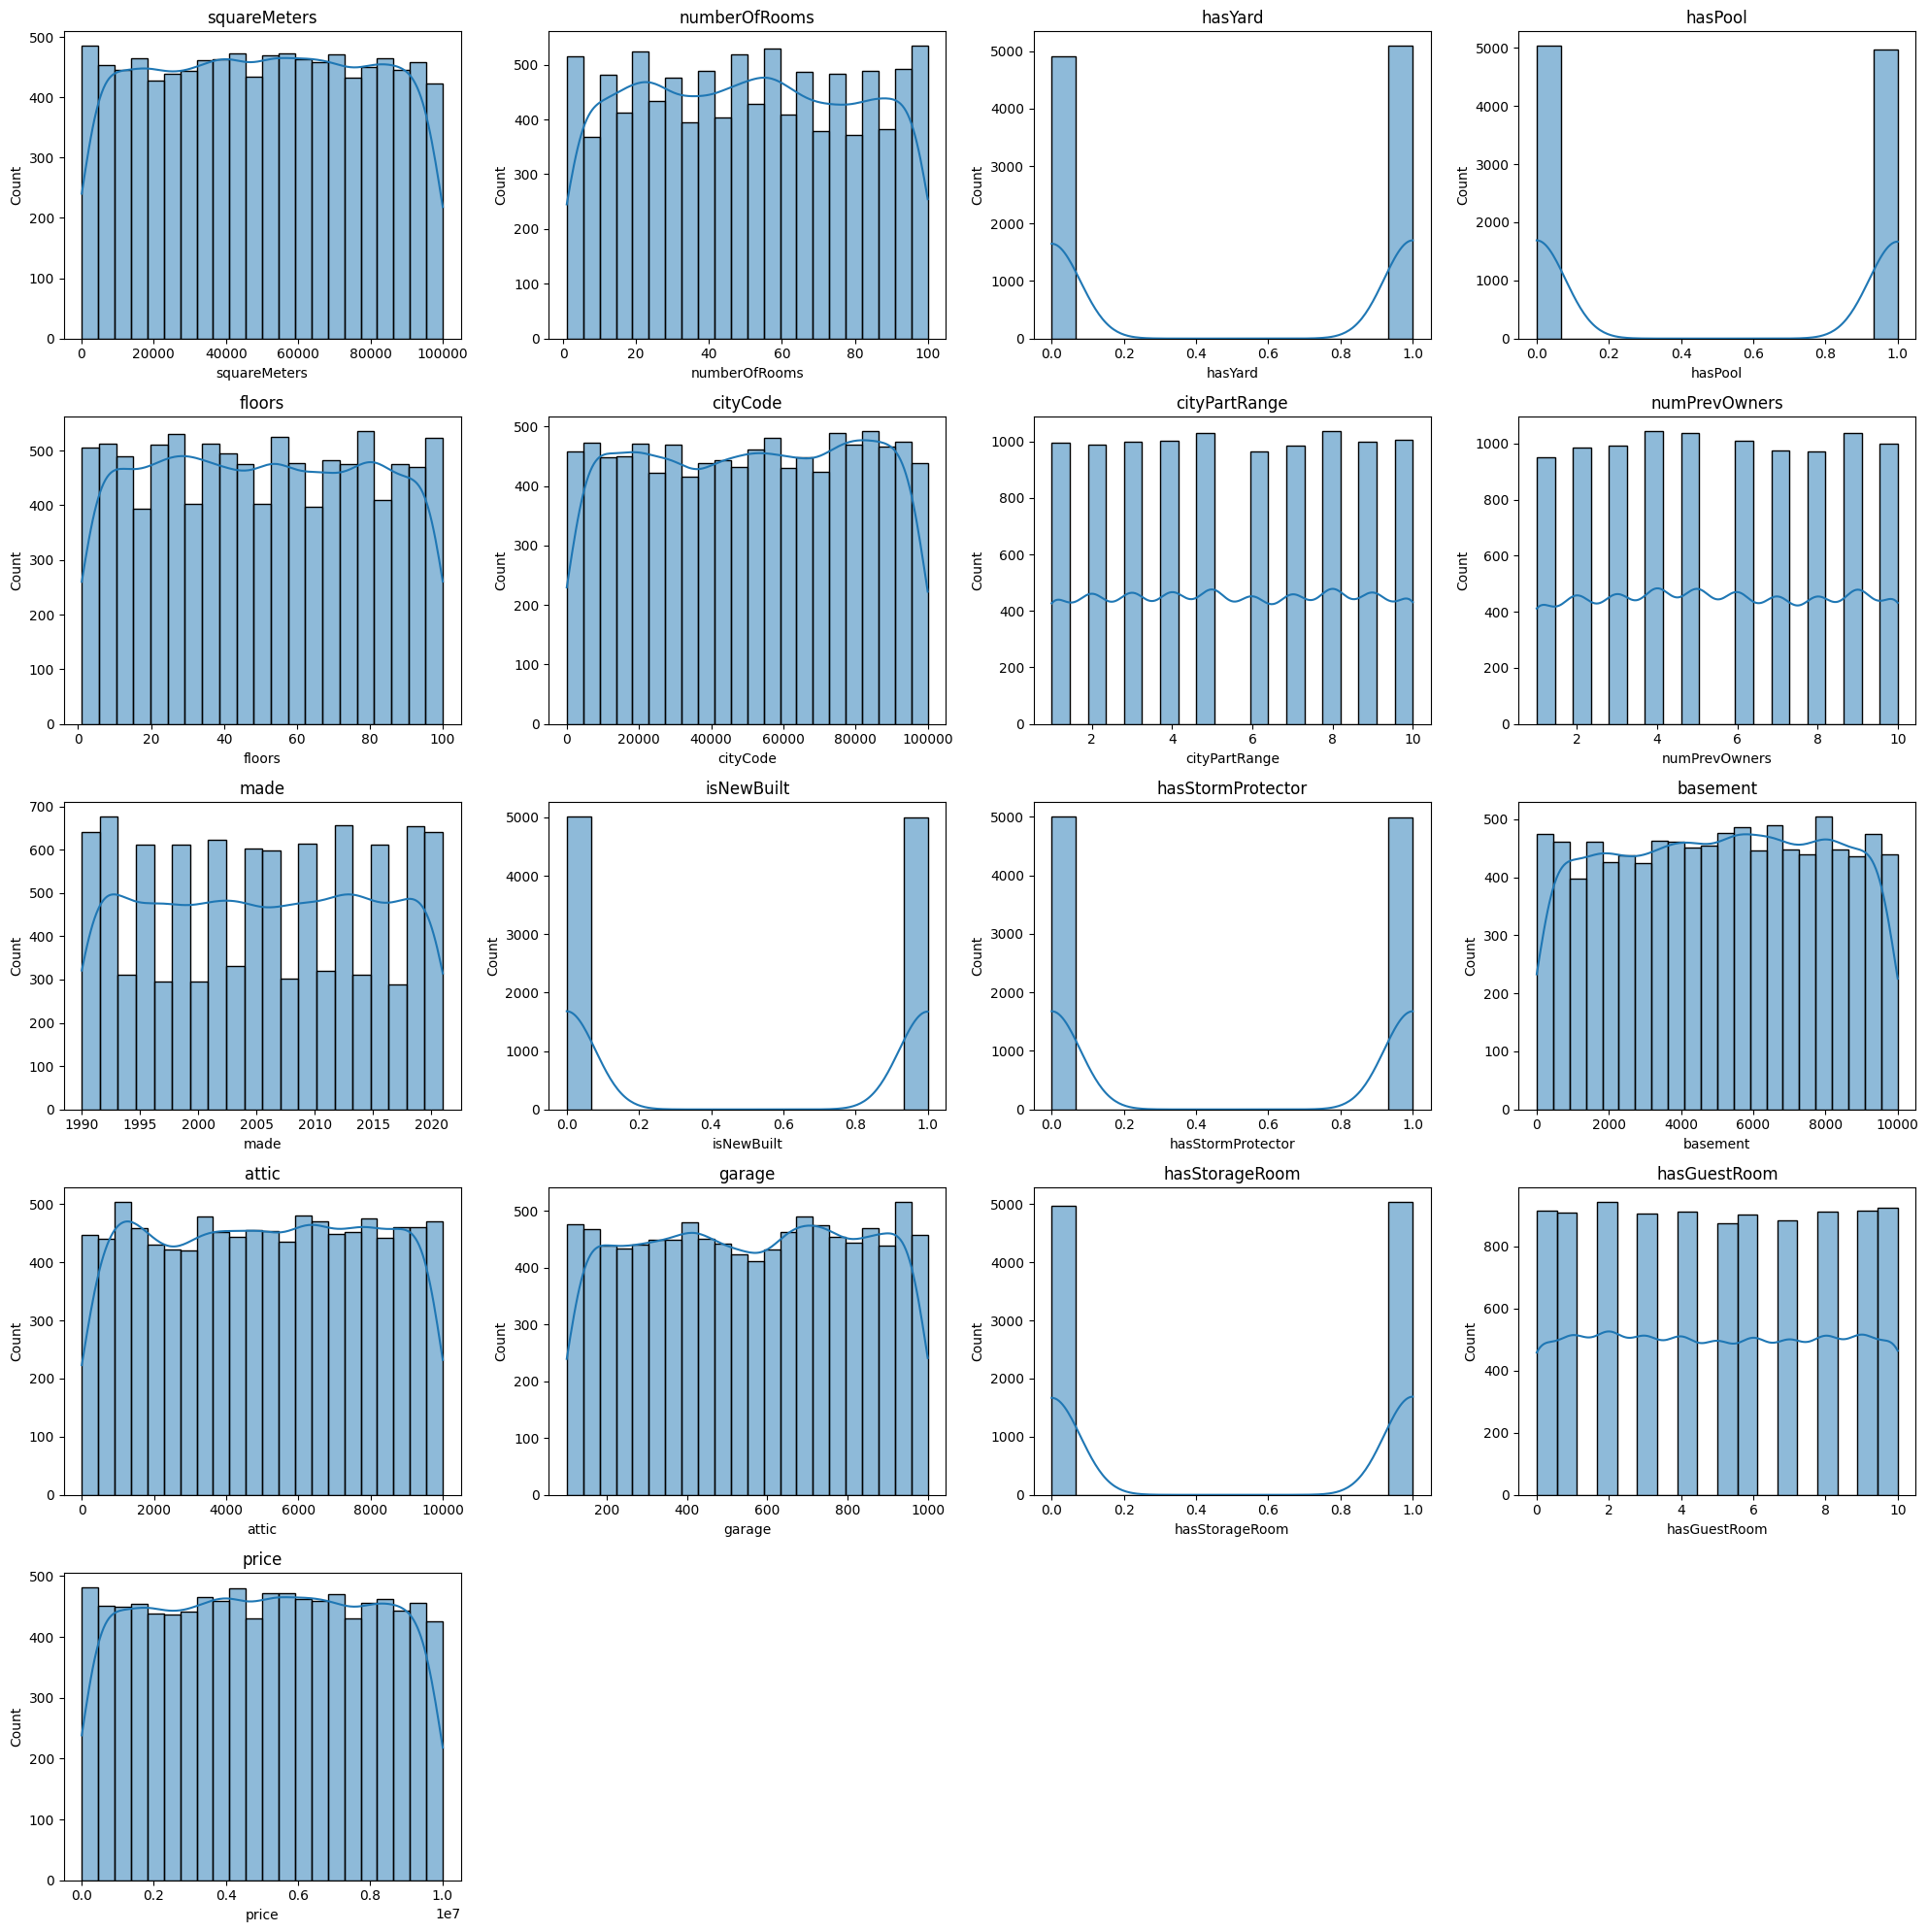

In [6]:
# plot the histogram kde plot for each feature using seaborn as a grid
plt.figure(figsize=(20, 20))
for i, column in enumerate(paris_real_estate_df.columns):
    plt.subplot(5, 4, i + 1)
    sns.histplot(paris_real_estate_df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

From the histogram plot above, we can see that the following features are binary in nature and should be treated as categorical features:

- `hasYard`
- `hasPool`
- `isNewBuilt`
- `hasStormProtector`
- `hasStorageRoom`

And there are some features that appear to be categorical. We shall inspect the number of unique values and their counts to confirm this.

- `cityPartRange`
- `numPrevOwners`
- `hasGuestRoom`

In [7]:
# inspect the unique values and their counts for potential categorical features
categorical_features = ['cityPartRange', 'numPrevOwners', 'hasGuestRoom']
for feature in categorical_features:
    unique_counts = paris_real_estate_df[feature].value_counts().reset_index()
    unique_counts.columns = ['Value', 'Count']
    print(f"\nUnique values and counts for {feature}:")
    unique_counts = unique_counts.sort_values(by='Value')
    print(tabulate(unique_counts, headers='keys', tablefmt='grid'))


Unique values and counts for cityPartRange:
+----+---------+---------+
|    |   Value |   Count |
+====+=========+=========+
|  6 |       1 |     994 |
+----+---------+---------+
|  7 |       2 |     990 |
+----+---------+---------+
|  4 |       3 |     999 |
+----+---------+---------+
|  3 |       4 |    1001 |
+----+---------+---------+
|  1 |       5 |    1031 |
+----+---------+---------+
|  9 |       6 |     965 |
+----+---------+---------+
|  8 |       7 |     984 |
+----+---------+---------+
|  0 |       8 |    1035 |
+----+---------+---------+
|  5 |       9 |     997 |
+----+---------+---------+
|  2 |      10 |    1004 |
+----+---------+---------+

Unique values and counts for numPrevOwners:
+----+---------+---------+
|    |   Value |   Count |
+====+=========+=========+
|  9 |       1 |     952 |
+----+---------+---------+
|  6 |       2 |     987 |
+----+---------+---------+
|  5 |       3 |     991 |
+----+---------+---------+
|  0 |       4 |    1043 |
+----+---------+---

All these three features appear to be categorical in nature as they have a limited number of unique values. We shall treat them as categorical features.

These are already labeled and do not require any further processing.

In [8]:
# describe the dataset
paris_real_estate_description = paris_real_estate_df.describe().transpose()

paris_real_estate_description

,count,mean,std,min,25%,50%,75%,max
squareMeters,10000.0,4.987013e+04,2.877438e+04,89.0,25098.50,50105.5,74609.75,99999.0
numberOfRooms,10000.0,5.035840e+01,2.881670e+01,1.0,25.00,50.0,75.00,100.0
hasYard,10000.0,5.087000e-01,4.999493e-01,0.0,0.00,1.0,1.00,1.0
hasPool,10000.0,4.968000e-01,5.000148e-01,0.0,0.00,0.0,1.00,1.0
floors,10000.0,5.027630e+01,2.888917e+01,1.0,25.00,50.0,76.00,100.0
cityCode,10000.0,5.022549e+04,2.900668e+04,3.0,24693.75,50693.0,75683.25,99953.0
cityPartRange,10000.0,5.510100e+00,2.872024e+00,1.0,3.00,5.0,8.00,10.0
numPrevOwners,10000.0,5.521700e+00,2.856667e+00,1.0,3.00,5.0,8.00,10.0
made,10000.0,2.005488e+03,9.308090e+00,1990.0,1997.00,2005.5,2014.00,2021.0
isNewBuilt,10000.0,4.991000e-01,5.000242e-01,0.0,0.00,0.0,1.00,1.0


### Checking for outliers

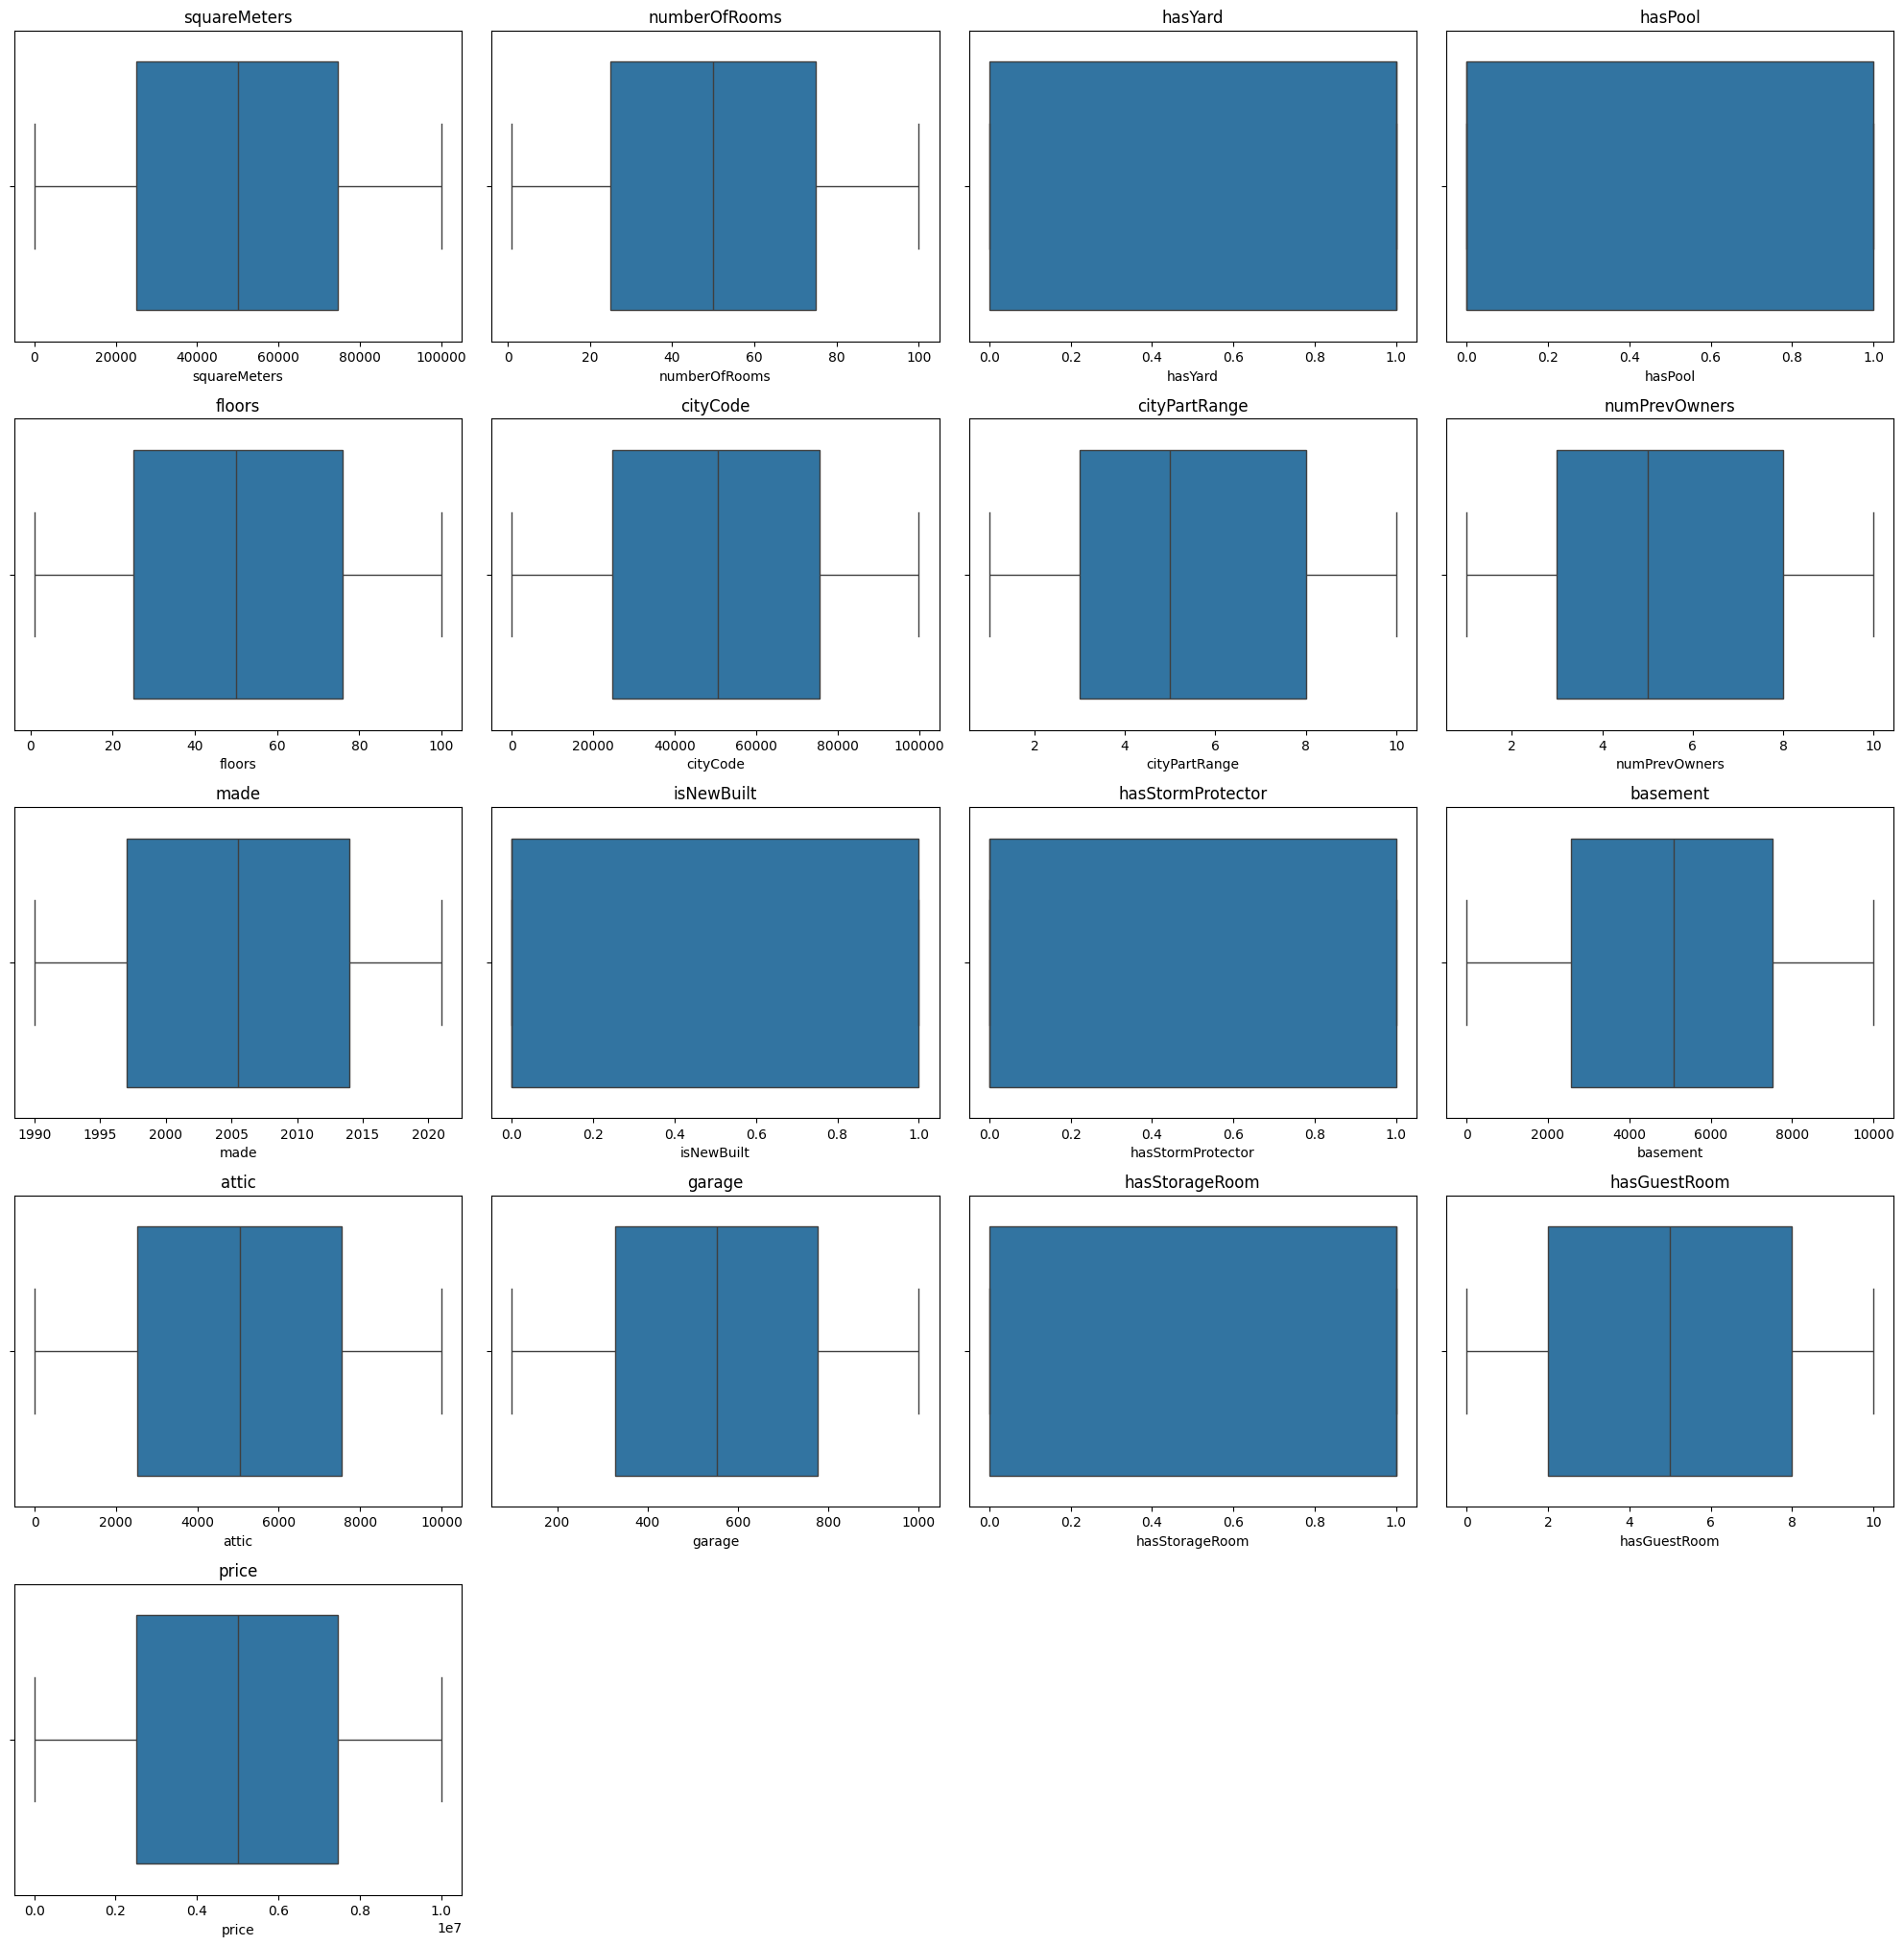

In [9]:
# plot boxplots for all features to identify outliers
plt.figure(figsize=(20, 24))
for i, column in enumerate(paris_real_estate_df.columns):
    plt.subplot(6, 4, i + 1)
    sns.boxplot(x=paris_real_estate_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

There don't seem to be any outliers in the dataset, as can be seen from the boxplot above. The features are already in a suitable format for modeling.

In [10]:
# number of unique values in cityCode
unique_city_codes = paris_real_estate_df['cityCode'].nunique()
print(f"\nNumber of unique city codes: {unique_city_codes}")


Number of unique city codes: 9509


Based on the descriptive statistics of the dataset, and the histogram plots, we can summarize the features as follows:

- There are 17 features in total.
- The target feature is `price`.
- There are no missing values in the dataset.
- Based on the box plots, there are no significant outliers in the dataset.
- Some of the features are binary and should be treated as categorical features:
  - `hasYard`
  - `hasPool`
  - `isNewBuilt`
  - `hasStormProtector`
  - `hasStorageRoom`
- Some features appear to be categorical based on the number of unique values:
  - `cityPartRange`
  - `numPrevOwners`
  - `hasGuestRoom` 
- `cityCode` may not be necessary for the model, as we can use `cityPartRange` to represent the city part.
- `made` must be treated as a categorical feature, as it represents the year the property was built and has a limited number of unique values.
- `price` does not vary much based on the year the property was built, as per the plots made per city part over the years.

### Price Analysis over the Years for each City Part

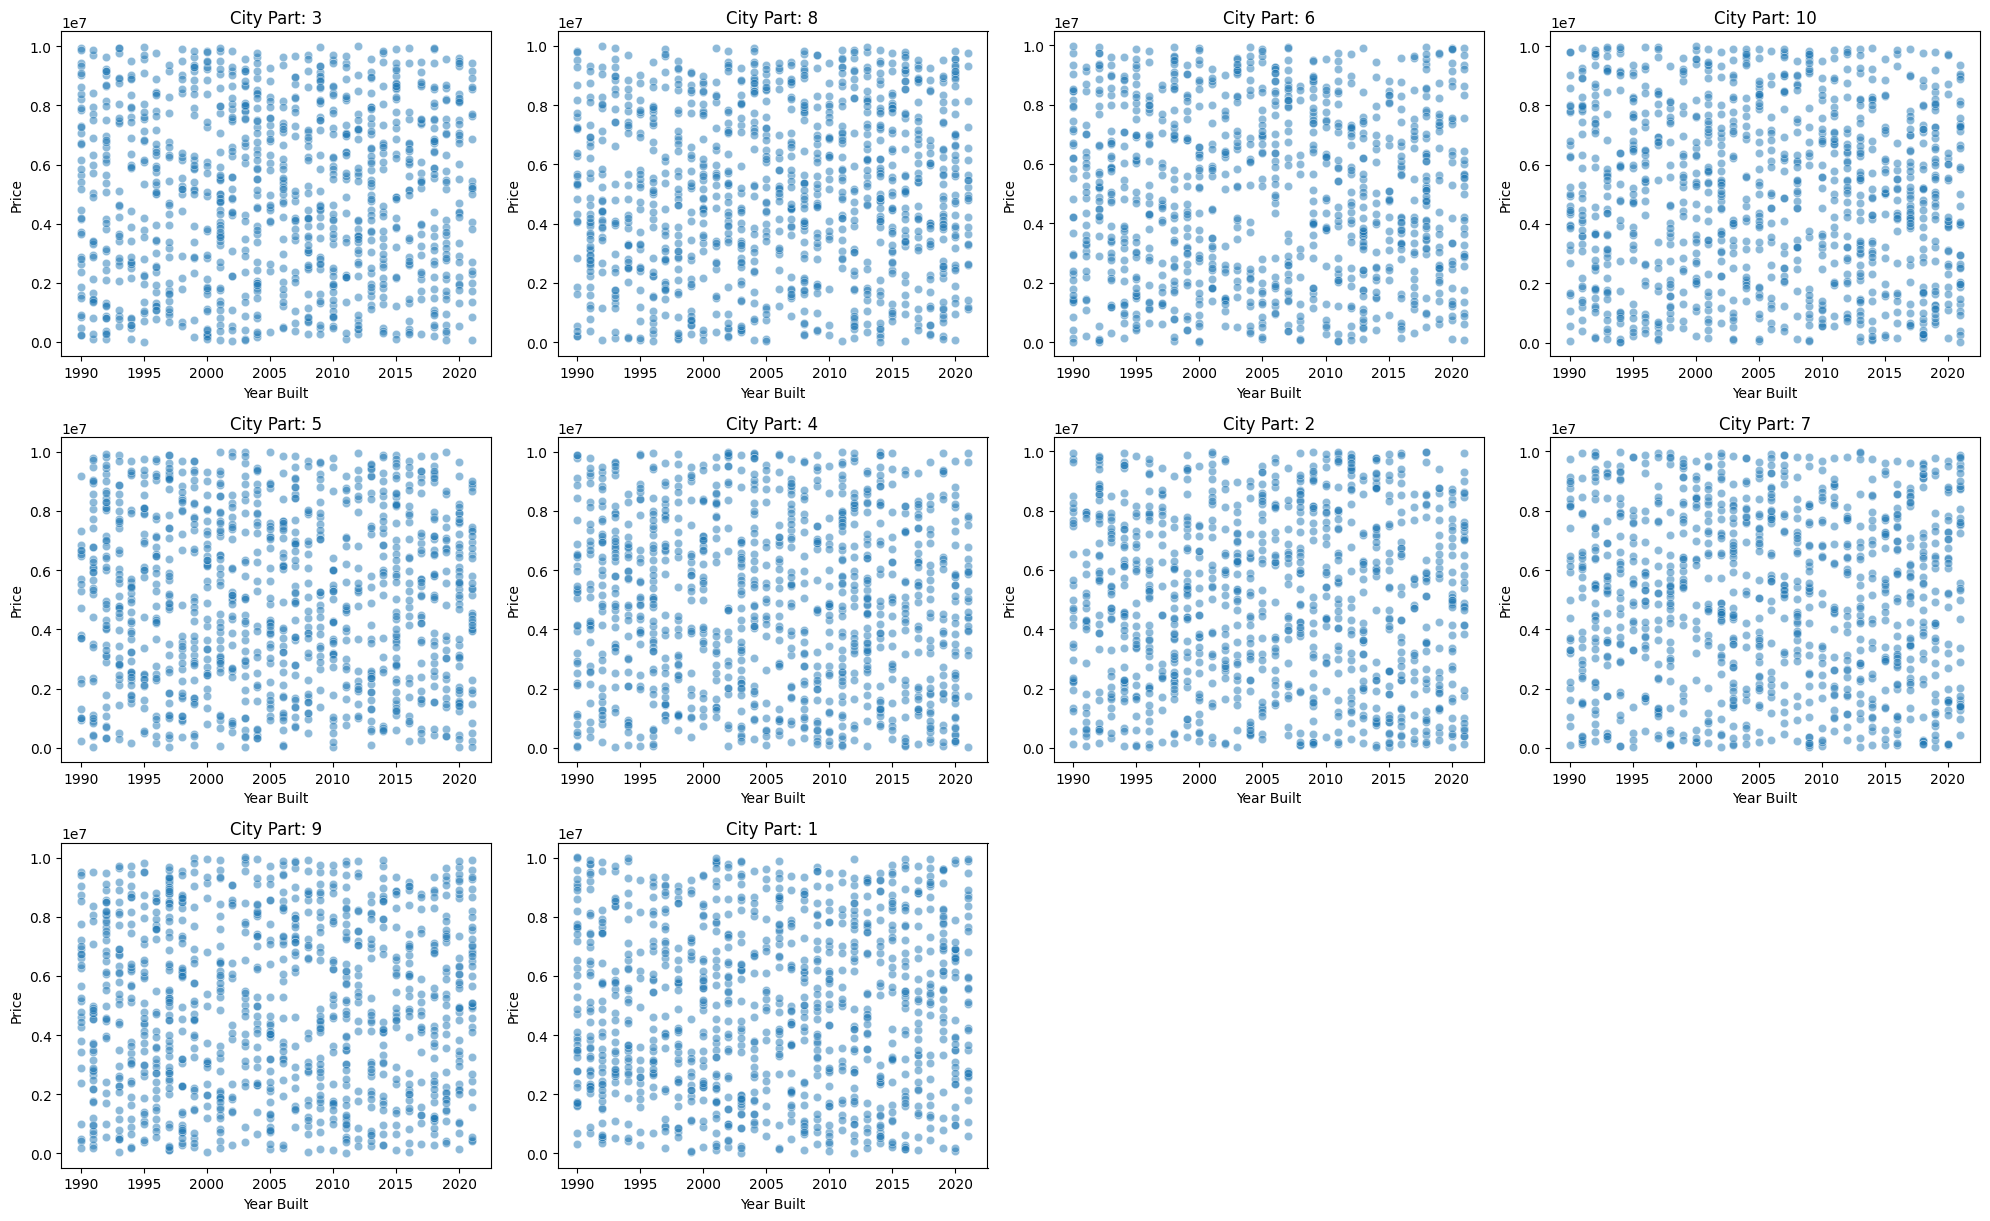

In [11]:
# for a given cityPartRange, plot the price vs yearBuilt in a grid of plots
city_part_ranges = paris_real_estate_df['cityPartRange'].unique()
plt.figure(figsize=(20, 20))
for i, city_part in enumerate(city_part_ranges):
    plt.subplot(5, 4, i + 1)
    subset = paris_real_estate_df[paris_real_estate_df['cityPartRange'] == city_part]
    sns.scatterplot(x=subset['made'], y=subset['price'], alpha=0.5)
    plt.title(f'City Part: {city_part}')
    plt.xlabel('Year Built')
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

Based on the plots above, it looks like the prices of the houses don't vary much based on the year they were built. They are more or less uniformly distributed across the years.

### Summary of Data Exploration

## Data Preprocessing

### Dropping and Changing Feature Types

In [12]:
# Drop the 'cityCode' feature as it has too many unique values
paris_real_estate_processing = paris_real_estate_df.drop(columns=['cityCode'])

In [13]:
# binary features that should be treated as categorical
binary_features = ['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']
for feature in binary_features:
    paris_real_estate_processing[feature] = paris_real_estate_processing[feature].astype('category')

In [14]:
# other categorical features
categorical_features = ['cityPartRange', 'numPrevOwners', 'hasGuestRoom']
for feature in categorical_features:
    paris_real_estate_processing[feature] = paris_real_estate_processing[feature].astype('category')

Till now, we did the following preprocessing steps:

- Dropped the `cityCode` feature as it has too many unique values.
- Converted the binary features to categorical features
- Converted the already identified categorical features to categorical data type. These are already labeled and do not require any further processing.

Let us now encode the `made` and `cityPartRange` features as categorical features.

For `made`, since it represents the year the property was built, simply converting it to a categorical type is sufficient. This will allow the model to treat it as a categorical feature without needing further encoding.

This is because years have natural ordering and meaningful distance criteria already.

For `cityPartRange`, we can use one-hot encoding to represent the different city parts.

### Correlation Analysis

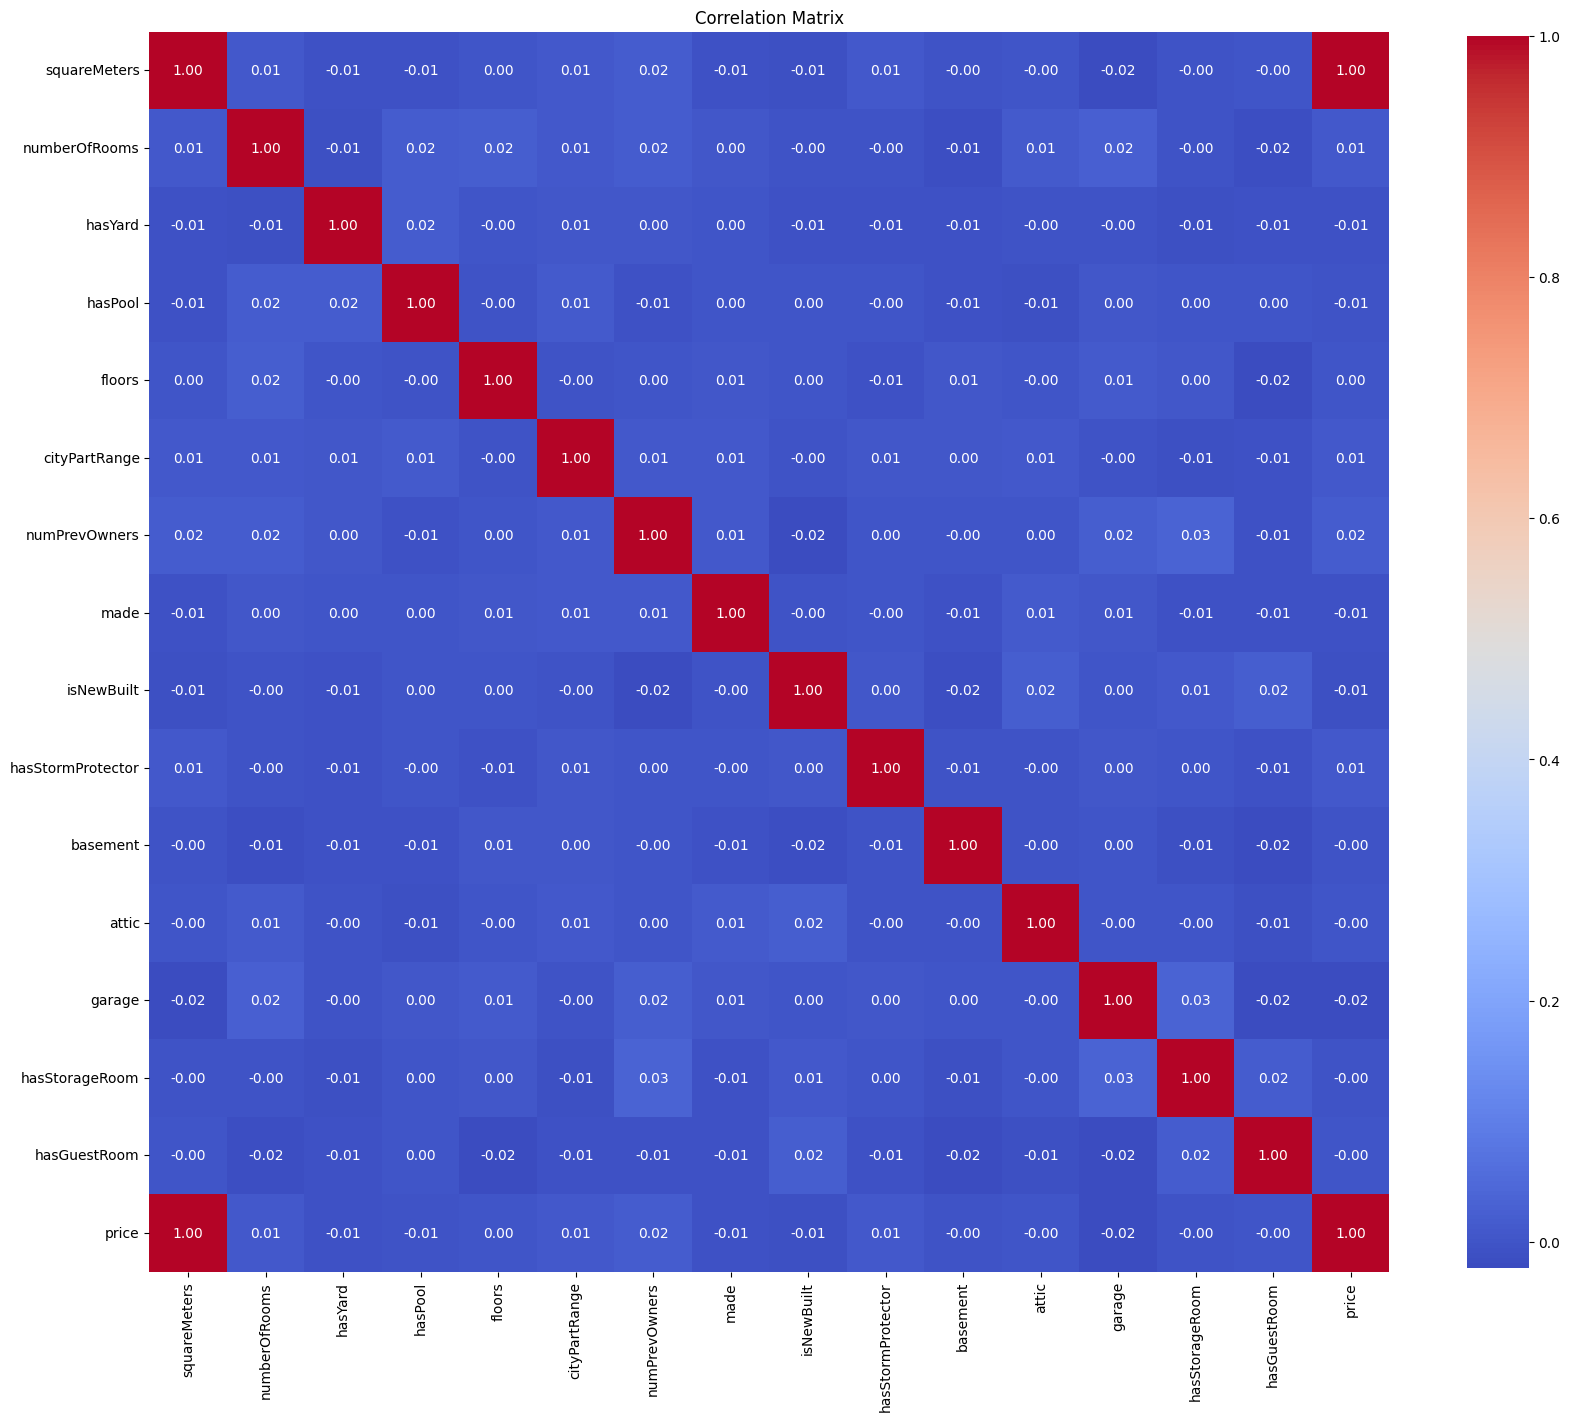

In [15]:
# check correlation matrix
plt.figure(figsize=(20, 20))
correlation_matrix = paris_real_estate_processing.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()  

There is a PERFECT correlation between `price` and `squareMeters`, which is strange in the real world, but it is what it is in this dataset. This means that the price of a property is directly proportional to its size in square meters.

There doesn't seem to be any heavy correlation between the input features, so we can proceed with the preprocessing steps without worrying about multicollinearity.

### Splitting the Dataset for Training and Testing

In [16]:
# save the processed DataFrame to a CSV file
paris_real_estate_processing.to_csv('paris_real_estate_processed.csv', index=False)

In [17]:
# train and test split
X = paris_real_estate_processing.drop(columns=['price'])
y = paris_real_estate_processing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### One-Hot Encoding of Categorical Feature - `cityPartRange`

In [18]:
# categorical encoding for 'made' and one-hot encoding for 'cityPartRange' for training and testing sets
X_train = pd.get_dummies(X_train, columns=['cityPartRange'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['cityPartRange'], drop_first=True)

# change the feature 'made' to categorical for both training and testing sets
X_train['made'] = X_train['made'].astype('category')
X_test['made'] = X_test['made'].astype('category')

In [19]:
# print the train and test sets structure
print("\nTraining set structure:")
print(tabulate(X_train.dtypes.reset_index(), headers=['Feature', 'Data Type'], tablefmt='grid'))
print("\nTesting set structure:")
print(tabulate(X_test.dtypes.reset_index(), headers=['Feature', 'Data Type'], tablefmt='grid')) 


Training set structure:
+----+-------------------+-------------+
|    | Feature           | Data Type   |
+====+===================+=============+
|  0 | squareMeters      | int64       |
+----+-------------------+-------------+
|  1 | numberOfRooms     | int64       |
+----+-------------------+-------------+
|  2 | hasYard           | category    |
+----+-------------------+-------------+
|  3 | hasPool           | category    |
+----+-------------------+-------------+
|  4 | floors            | int64       |
+----+-------------------+-------------+
|  5 | numPrevOwners     | category    |
+----+-------------------+-------------+
|  6 | made              | category    |
+----+-------------------+-------------+
|  7 | isNewBuilt        | category    |
+----+-------------------+-------------+
|  8 | hasStormProtector | category    |
+----+-------------------+-------------+
|  9 | basement          | int64       |
+----+-------------------+-------------+
| 10 | attic             | int64

In [20]:
# shape of the train and test sets
print(f"\nShape of the training set: {X_train.shape}")
print(f"Shape of the testing set: {X_test.shape}")


Shape of the training set: (8000, 23)
Shape of the testing set: (2000, 23)


### Standardization of Numerical Features

Below features of the dataset need to be standardized:

- squareMeters
- numberOfRooms
- floors
- basement
- attic
- garage

In [21]:
# standardize the features that need to be standardized
features_to_standardize = ['squareMeters', 'numberOfRooms', 'floors', 'basement', 'attic', 'garage']
scaler = StandardScaler()
X_train[features_to_standardize] = scaler.fit_transform(X_train[features_to_standardize])
X_test[features_to_standardize] = scaler.transform(X_test[features_to_standardize])

In [22]:
# write the processed training and testing sets to CSV files
X_train.to_csv('X_train_processed.csv', index=False)
X_test.to_csv('X_test_processed.csv', index=False)
y_train.to_csv('y_train_processed.csv', index=False)
y_test.to_csv('y_test_processed.csv', index=False)

## Model Building

Since the target feature `price` is a continuous variable, we will use regression models to predict the price of the properties. 

Based on the instructions, the following metrics will be used to evaluate the models:

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R-squared (R2)

We shall try the following regression models:

- Linear Regression
- Random Forest Regressor  
- Gradient Boosting Regressor

We shall use K-Fold Cross-Validation to evaluate the models. This will help us to get a better estimate of the model's performance on unseen data.

### Linear Regression with K-Fold Cross-Validation

In [23]:
# kf object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# build a linear regression model with default parameters
linear_model = LinearRegression()

# do cross-validation
linear_scores = cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# get MSE scores
linear_mse_scores = -linear_scores  # negate the scores to get positive MSE values

# get RMSE scores
linear_rmse_scores = linear_mse_scores ** 0.5

# get R^2 scores
linear_r2_scores = cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='r2')

# print all three scores using tabulate
linear_scores_table = pd.DataFrame({
    'Fold': range(1, len(linear_mse_scores) + 1),
    'MSE': linear_mse_scores,
    'RMSE': linear_rmse_scores,
    'R^2': linear_r2_scores
})
print("\nLinear Regression Model Cross-Validation Scores:")
print(tabulate(linear_scores_table, headers='keys', tablefmt='grid'))


Linear Regression Model Cross-Validation Scores:
+----+--------+-------------+---------+-------+
|    |   Fold |         MSE |    RMSE |   R^2 |
+====+========+=============+=========+=======+
|  0 |      1 | 3.45209e+06 | 1857.98 |     1 |
+----+--------+-------------+---------+-------+
|  1 |      2 | 3.7382e+06  | 1933.44 |     1 |
+----+--------+-------------+---------+-------+
|  2 |      3 | 3.59468e+06 | 1895.96 |     1 |
+----+--------+-------------+---------+-------+
|  3 |      4 | 3.59279e+06 | 1895.47 |     1 |
+----+--------+-------------+---------+-------+
|  4 |      5 | 3.61312e+06 | 1900.82 |     1 |
+----+--------+-------------+---------+-------+


As seen above, the R-squared value for the Linear Regression model is 1.0, which indicates that the model is able to explain 100% of the variance in the target variable `price`. 

This is unusual and generally indicates that the model is overfitting the training data. In real-world scenarios, we would expect the R-squared value to be less than 1.0, indicating that the model is not able to explain all the variance in the target variable.

However, since the squareMeters feature is perfectly correlated with the price, the model is probably been able to explain all the variance in the target variable.

**Summary of K-Fold Cross-Validation for Linear Regression:**

Based on the 5 folds of cross-validation, we see an uniform performance across all the folds.

### Random Forest Regressor with K-Fold Cross-Validation

In [24]:
# random forest regressor with default parameters
rf_model = RandomForestRegressor(random_state=42)

# do cross-validation
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# get MSE scores
rf_mse_scores = -rf_scores  # negate the scores to get positive MSE values

# get RMSE scores
rf_rmse_scores = rf_mse_scores ** 0.5

# get R^2 scores
rf_r2_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')

# print all three scores using tabulate
rf_scores_table = pd.DataFrame({
    'Fold': range(1, len(rf_mse_scores) + 1),
    'MSE': rf_mse_scores,
    'RMSE': rf_rmse_scores,
    'R^2': rf_r2_scores
})
print("\nRandom Forest Regressor Cross-Validation Scores:")
print(tabulate(rf_scores_table, headers='keys', tablefmt='grid'))


Random Forest Regressor Cross-Validation Scores:
+----+--------+-------------+---------+----------+
|    |   Fold |         MSE |    RMSE |      R^2 |
+====+========+=============+=========+==========+
|  0 |      1 | 1.55182e+07 | 3939.32 | 0.999998 |
+----+--------+-------------+---------+----------+
|  1 |      2 | 1.63487e+07 | 4043.36 | 0.999998 |
+----+--------+-------------+---------+----------+
|  2 |      3 | 1.51776e+07 | 3895.84 | 0.999998 |
+----+--------+-------------+---------+----------+
|  3 |      4 | 1.62967e+07 | 4036.92 | 0.999998 |
+----+--------+-------------+---------+----------+
|  4 |      5 | 1.49416e+07 | 3865.44 | 0.999998 |
+----+--------+-------------+---------+----------+


Based on the 5 folds of cross-validation, here are the observations:

- The performance of the Random Forest Regressor is consistent across all folds.
- We still see a near-perfect R-squared value of 1.0, indicating that the model is able to explain 100% of the variance in the target variable `price`.
- Both MSE and RMSE values are higher than those of the Linear Regression model, indicating that the Random Forest Regressor is not performing as well as the Linear Regression model in this case.
- This lower performance of Random Forest Regressor indicates that there is a much better linear relationship between the input features and the target feature `price`, which is why the Linear Regression model is performing better. And this is expected as the `squareMeters` feature is perfectly correlated with the `price` feature, which is a linear relationship.

In [25]:
# gradient boosting regressor with default parameters
gb_model = GradientBoostingRegressor(random_state=42)

# do cross-validation
gb_scores = cross_val_score(gb_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# get MSE scores
gb_mse_scores = -gb_scores  # negate the scores to get positive MSE values

# get RMSE scores
gb_rmse_scores = gb_mse_scores ** 0.5

# get R^2 scores
gb_r2_scores = cross_val_score(gb_model, X_train, y_train, cv=kf, scoring='r2')

# print all three scores using tabulate
gb_scores_table = pd.DataFrame({
    'Fold': range(1, len(gb_mse_scores) + 1),
    'MSE': gb_mse_scores,
    'RMSE': gb_rmse_scores,
    'R^2': gb_r2_scores
})
print("\nGradient Boosting Regressor Cross-Validation Scores:")
print(tabulate(gb_scores_table, headers='keys', tablefmt='grid'))


Gradient Boosting Regressor Cross-Validation Scores:
+----+--------+-------------+---------+----------+
|    |   Fold |         MSE |    RMSE |      R^2 |
+====+========+=============+=========+==========+
|  0 |      1 | 4.24776e+08 | 20610.1 | 0.999948 |
+----+--------+-------------+---------+----------+
|  1 |      2 | 4.17423e+08 | 20430.9 | 0.999948 |
+----+--------+-------------+---------+----------+
|  2 |      3 | 4.38822e+08 | 20948.1 | 0.999945 |
+----+--------+-------------+---------+----------+
|  3 |      4 | 4.04133e+08 | 20103.1 | 0.999953 |
+----+--------+-------------+---------+----------+
|  4 |      5 | 4.15427e+08 | 20382   | 0.999949 |
+----+--------+-------------+---------+----------+


Here are the observations based on the K-Fold Cross-Validation for Gradient Boosting Regressor:

- The performance of the Gradient Boosting Regressor is consistent across all folds.
- We still see a near-perfect R-squared value of 1.0, indicating that the model is able to explain 100% of the variance in the target variable `price`.
- Both MSE and RMSE values are higher than those of the Linear Regression model as well as the Random Forest Regressor. GBR is probably overfitting the training data as well, but not as much as the Random Forest Regressor.

### Compare the three models with MSE, RMSE, and R-squared values

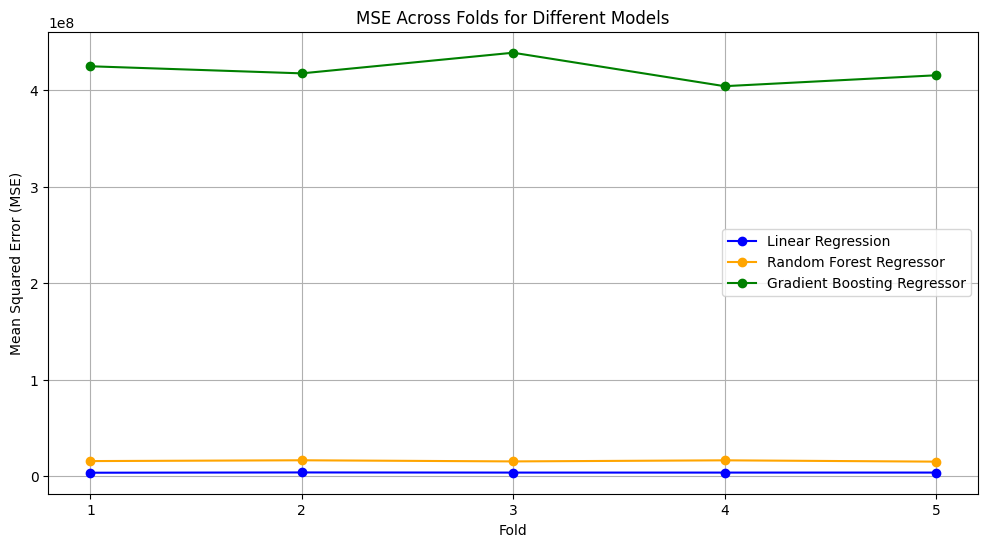

In [26]:
# plot the mse across the folds for all three models
plt.figure(figsize=(12, 6))
plt.plot(linear_scores_table['Fold'], linear_scores_table['MSE'], marker='o', label='Linear Regression', color='blue')
plt.plot(rf_scores_table['Fold'], rf_scores_table['MSE'], marker='o', label='Random Forest Regressor', color='orange')
plt.plot(gb_scores_table['Fold'], gb_scores_table['MSE'], marker='o', label='Gradient Boosting Regressor', color='green')
plt.title('MSE Across Folds for Different Models')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(linear_scores_table['Fold'])
plt.legend()
plt.grid()
plt.show()

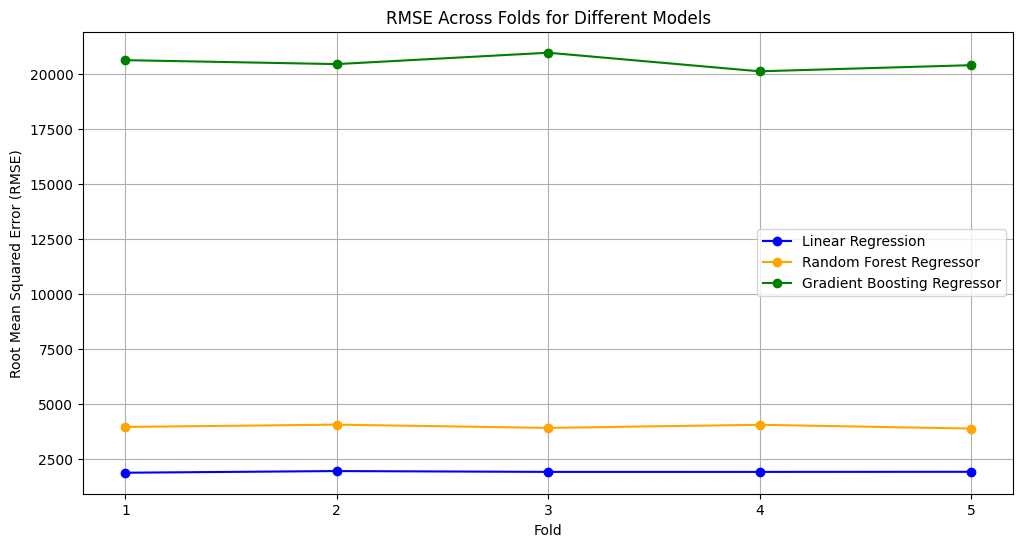

In [27]:
# plot the rmse across the folds for all three models
plt.figure(figsize=(12, 6))
plt.plot(linear_scores_table['Fold'], linear_scores_table['RMSE'], marker='o', label='Linear Regression', color='blue')
plt.plot(rf_scores_table['Fold'], rf_scores_table['RMSE'], marker='o', label='Random Forest Regressor', color='orange')
plt.plot(gb_scores_table['Fold'], gb_scores_table['RMSE'], marker='o', label='Gradient Boosting Regressor', color='green')
plt.title('RMSE Across Folds for Different Models')
plt.xlabel('Fold')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(linear_scores_table['Fold'])
plt.legend()
plt.grid()
plt.show()

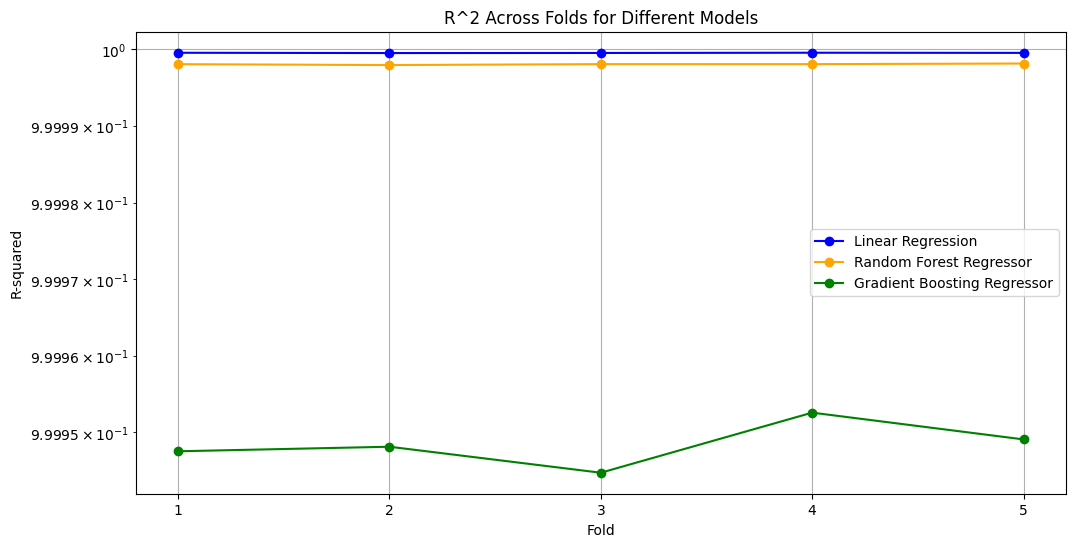

In [28]:
# plot the R^2 across the folds for all three models
plt.figure(figsize=(12, 6))
plt.plot(linear_scores_table['Fold'], linear_scores_table['R^2'], marker='o', label='Linear Regression', color='blue')
plt.plot(rf_scores_table['Fold'], rf_scores_table['R^2'], marker='o', label='Random Forest Regressor', color='orange')
plt.plot(gb_scores_table['Fold'], gb_scores_table['R^2'], marker='o', label='Gradient Boosting Regressor', color='green')
plt.title('R^2 Across Folds for Different Models')
plt.xlabel('Fold')
plt.ylabel('R-squared')
# use log scale for y-axis
plt.yscale('log')
plt.xticks(linear_scores_table['Fold'])
plt.legend()
plt.grid()
plt.show()

| Model | Mean MSE | Mean RMSE | Mean R² | Performance Notes |
|-------|----------|-----------|---------|-------------------|
| Linear Regression | 3.61M | 1,897 | 1.000000 | Perfect fit due to linear relationship |
| Random Forest | 15.54M | 3,939 | 0.999998 | Near-perfect but adds complexity noise |
| Gradient Boosting | 424.77M | 20,610 | 0.999949 | Worst performance despite high R² |

### Key Insights in comparison of the three models:

**Performance Ranking (Best to Worst):**

1. **Linear Regression** - Perfect for this linear relationship
2. **Random Forest** - 4x higher MSE, slight imperfection 
3. **Gradient Boosting** - 118x higher MSE, significant overfitting

**Why This Happened:**

- All models achieve near-perfect R² due to the `squareMeters` perfect correlation
- **Linear Regression wins** because the true relationship is perfectly linear
- **Tree-based models (RF, GB) add unnecessary complexity** to a simple linear pattern
- **Gradient Boosting performs worst** - likely overfitting to training noise with aggressive boosting

**Conclusion:**

This demonstrates that **model complexity should match data complexity**. For perfectly linear relationships, simple linear regression is optimal. The tree-based models are solving the wrong problem - they're designed for non-linear patterns that don't exist in this dataset.

## Feature Importance Analysis

In [29]:
# number of features in training set
num_features = X_train.shape[1]
print(f"\nNumber of features in training set: {num_features}")


Number of features in training set: 23


We have 23 features in the training set. As seen earlier, the `squareMeters` feature dominates the dataset, and the model is able to explain 100% of the variance in the target variable `price`.

However, let's analyze the feature importance to understand the contribution of each feature in the model.

We shall use two methods to analyze feature importance:

1. Use model-specific feature importance for each of the three models - linear regression, random forest regressor, and gradient boosting regressor.
2. Use Permutation Importance to analyze feature importance statistically.

### Feature Importance from Linear Regression Model

In [30]:
# feature importance from linear regression model
linear_model.fit(X_train, y_train)
linear_feature_importance = pd.Series(linear_model.coef_, index=X_train.columns).sort_values(ascending=False)
print("\nFeature Importance from Linear Regression Model:")
print(tabulate(linear_feature_importance.reset_index(), headers=['Feature', 'Importance'], tablefmt='grid'))


Feature Importance from Linear Regression Model:
+----+-------------------+----------------+
|    | Feature           |     Importance |
+====+===================+================+
|  0 | squareMeters      |    2.85562e+06 |
+----+-------------------+----------------+
|  1 | hasYard           | 2993.76        |
+----+-------------------+----------------+
|  2 | hasPool           | 2991.69        |
+----+-------------------+----------------+
|  3 | floors            | 1576.63        |
+----+-------------------+----------------+
|  4 | cityPartRange_10  |  422.965       |
+----+-------------------+----------------+
|  5 | cityPartRange_8   |  379.101       |
+----+-------------------+----------------+
|  6 | cityPartRange_7   |  313.018       |
+----+-------------------+----------------+
|  7 | cityPartRange_9   |  244.526       |
+----+-------------------+----------------+
|  8 | cityPartRange_4   |  140.98        |
+----+-------------------+----------------+
|  9 | isNewBuilt        |

As can be seen from the output above, after the `squareMeters` feature, the next 3 most important features are

- `hasYard`
- `hasPool`
- `floors`

So, it looks like the cost of the property is also influenced by whether it has a yard or a pool, and the number of floors in the property. But looking at the coefficient value, the importance magnitude is much lower than that of the `squareMeters` feature.

After these, the `cityPartRange_10` seem to have the next highest importance, showing that this part of the city has a significant impact on the property prices, comparted to the other city parts.

### Feature Importance from Random Forest Regressor Model

In [31]:
# feature importance for Random Forest Regressor
rf_model.fit(X_train, y_train)
rf_feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nFeature Importance from Random Forest Regressor:")
print(tabulate(rf_feature_importance.reset_index(), headers=['Feature', 'Importance'], tablefmt='grid'))


Feature Importance from Random Forest Regressor:
+----+-------------------+--------------+
|    | Feature           |   Importance |
+====+===================+==============+
|  0 | squareMeters      |  0.999999    |
+----+-------------------+--------------+
|  1 | floors            |  1.45284e-07 |
+----+-------------------+--------------+
|  2 | attic             |  1.29809e-07 |
+----+-------------------+--------------+
|  3 | basement          |  1.17551e-07 |
+----+-------------------+--------------+
|  4 | numberOfRooms     |  1.16731e-07 |
+----+-------------------+--------------+
|  5 | garage            |  1.14993e-07 |
+----+-------------------+--------------+
|  6 | made              |  1.05406e-07 |
+----+-------------------+--------------+
|  7 | numPrevOwners     |  8.4345e-08  |
+----+-------------------+--------------+
|  8 | hasGuestRoom      |  8.35625e-08 |
+----+-------------------+--------------+
|  9 | hasYard           |  3.52412e-08 |
+----+-------------------+

Apparently, while `squareMeters` is the most important feature, the next most important features are different in Random Forest Regressor model. `floors` is the only common top 5 feature between Linear Regression and Random Forest Regressor models.

### Feature Importance from Gradient Boosting Regressor Model

In [32]:
# feature importance for gradient boosting regressor
gb_model.fit(X_train, y_train)
gb_feature_importance = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nFeature Importance from Gradient Boosting Regressor:")
print(tabulate(gb_feature_importance.reset_index(), headers=['Feature', 'Importance'], tablefmt='grid'))


Feature Importance from Gradient Boosting Regressor:
+----+-------------------+--------------+
|    | Feature           |   Importance |
+====+===================+==============+
|  0 | squareMeters      |  1           |
+----+-------------------+--------------+
|  1 | hasYard           |  1.31162e-07 |
+----+-------------------+--------------+
|  2 | garage            |  7.75311e-08 |
+----+-------------------+--------------+
|  3 | floors            |  6.63332e-08 |
+----+-------------------+--------------+
|  4 | attic             |  6.19079e-08 |
+----+-------------------+--------------+
|  5 | basement          |  5.77619e-08 |
+----+-------------------+--------------+
|  6 | numberOfRooms     |  3.33009e-08 |
+----+-------------------+--------------+
|  7 | hasPool           |  1.82584e-08 |
+----+-------------------+--------------+
|  8 | made              |  1.43651e-08 |
+----+-------------------+--------------+
|  9 | hasStorageRoom    |  4.66406e-09 |
+----+----------------

Putting aside the `squareMeters` feature, `hasYard` and `floors` seem to be the next most important top 5 features in the Gradient Boosting Regressor model that is in common with the Linear Regression model.

And `floors` is the only common top 5 feature between all three models, apart from the `squareMeters` feature.

### Feature Importance using Permutation Importance

Top 10 Features by Permutation Importance:
              feature  importance_mean  importance_std
0        squareMeters     1.741214e+13    4.302594e+11
4              floors     4.924961e+06    1.622324e+05
2             hasYard     4.652366e+06    1.870211e+05
3             hasPool     4.379227e+06    1.429769e+05
20    cityPartRange_8     2.528434e+04    5.282256e+03
7          isNewBuilt     1.522595e+04    5.928584e+03
8   hasStormProtector     1.483828e+04    4.426149e+03
22   cityPartRange_10     9.334888e+03    8.524798e+03
19    cityPartRange_7     8.980768e+03    6.071791e+03
21    cityPartRange_9     8.088532e+03    1.009687e+04


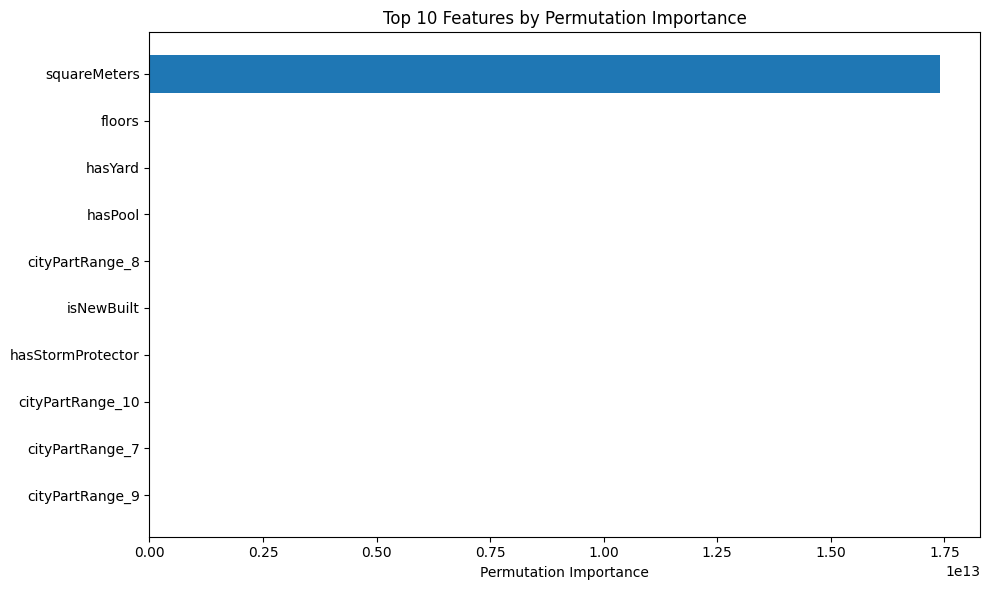

In [33]:
# Calculate permutation importance for linear regression model

linear_model.fit(X_train, y_train)

perm_importance = permutation_importance(
    linear_model, 
    X_test,  # Use test set for unbiased importance
    y_test, 
    n_repeats=10,  # Number of times to permute each feature
    random_state=42,
    scoring='neg_mean_squared_error'  # Use 'neg_mean_squared_error' for regression
)

# Get feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame with results
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean, # type: ignore
    'importance_std': perm_importance.importances_std # type: ignore
})

# Sort by importance and get top 10
top_10_features = importance_df.sort_values('importance_mean', ascending=False).head(10)

print("Top 10 Features by Permutation Importance:")
print(top_10_features)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(10), top_10_features['importance_mean'][::-1])
plt.yticks(range(10), top_10_features['feature'][::-1]) # type: ignore
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features by Permutation Importance')
plt.tight_layout()
plt.show()

Based on the Permutation Importance analysis, we can see that the `squareMeters` feature is by far the most important feature, followed by `floors`, `hasYard`, and `hasPool`.

Other than the primary feature `squareMeters`, the order of other features importance is different compared to the feature importance method used for linear regression.

Top 10 Features by Permutation Importance (Random Forest):
            feature  importance_mean  importance_std
0      squareMeters     1.741142e+13    4.302549e+11
4            floors     4.995251e+05    4.429422e+04
2           hasYard     1.989503e+05    1.815148e+04
3           hasPool     1.702045e+05    2.446529e+04
19  cityPartRange_7     1.785790e+04    6.289358e+03
11           garage     1.757543e+04    5.463395e+04
15  cityPartRange_3     1.502582e+04    3.796456e+03
17  cityPartRange_5     1.424378e+04    8.744775e+03
18  cityPartRange_6     5.768787e+03    5.841049e+03
14  cityPartRange_2     5.686958e+03    6.630488e+03


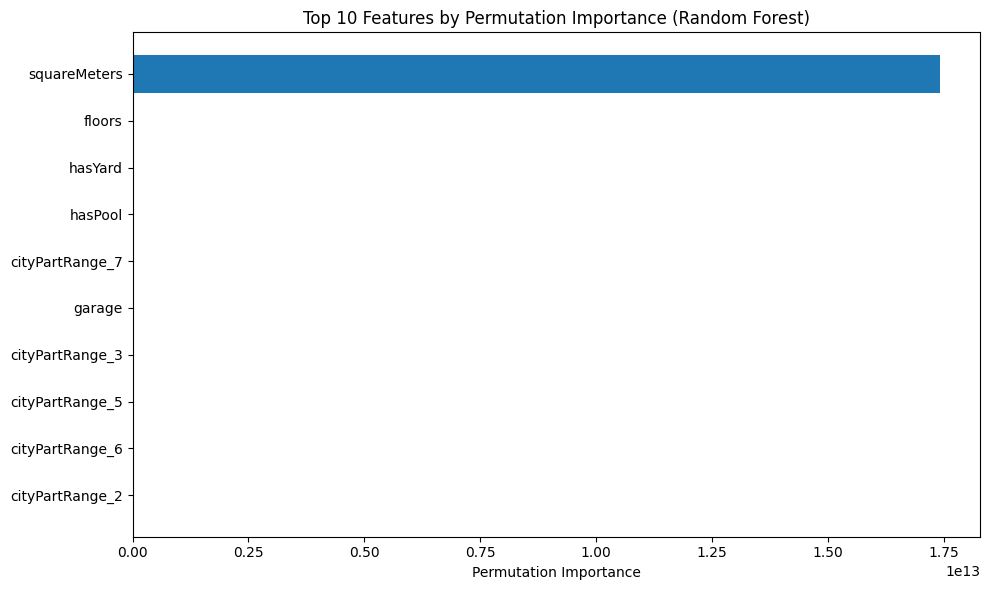

In [34]:
# Calculate permutation importance for random forest regressor model
rf_model.fit(X_train, y_train)  

perm_importance_rf = permutation_importance(
    rf_model, 
    X_test,  # Use test set for unbiased importance
    y_test, 
    n_repeats=10,  # Number of times to permute each feature
    random_state=42,
    scoring='neg_mean_squared_error'  # Use 'neg_mean_squared_error' for regression
)

# Get feature names (assuming X_train is a DataFrame)
feature_names_rf = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]        

# Create a DataFrame with results
importance_df_rf = pd.DataFrame({
    'feature': feature_names_rf,
    'importance_mean': perm_importance_rf.importances_mean, # type: ignore
    'importance_std': perm_importance_rf.importances_std # type: ignore
})

# Sort by importance and get top 10
top_10_features_rf = importance_df_rf.sort_values('importance_mean', ascending=False).head(10)  

print("Top 10 Features by Permutation Importance (Random Forest):")
print(top_10_features_rf)

# Plot the results for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(range(10), top_10_features_rf['importance_mean'][::-1])
plt.yticks(range(10), top_10_features_rf['feature'][::-1]) # type: ignore
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features by Permutation Importance (Random Forest)')
plt.tight_layout()
plt.show()


The top 4 features identified by Permutation Importance are same as those identified for the Linear regression model. And these are

- `squareMeters`
- `floors`
- `hasYard`
- `hasPool`

Top 10 Features by Permutation Importance (Gradient Boosting):
            feature  importance_mean  importance_std
0      squareMeters     1.741187e+13    4.297436e+11
2           hasYard     2.536033e+06    7.538711e+05
4            floors     3.936534e+05    4.462679e+05
10            attic     2.862578e+05    1.700958e+05
3           hasPool     1.718400e+05    9.321268e+04
1     numberOfRooms     1.435483e+05    1.335249e+05
12   hasStorageRoom     6.843709e+03    1.887792e+04
15  cityPartRange_3     0.000000e+00    0.000000e+00
21  cityPartRange_9     0.000000e+00    0.000000e+00
20  cityPartRange_8     0.000000e+00    0.000000e+00


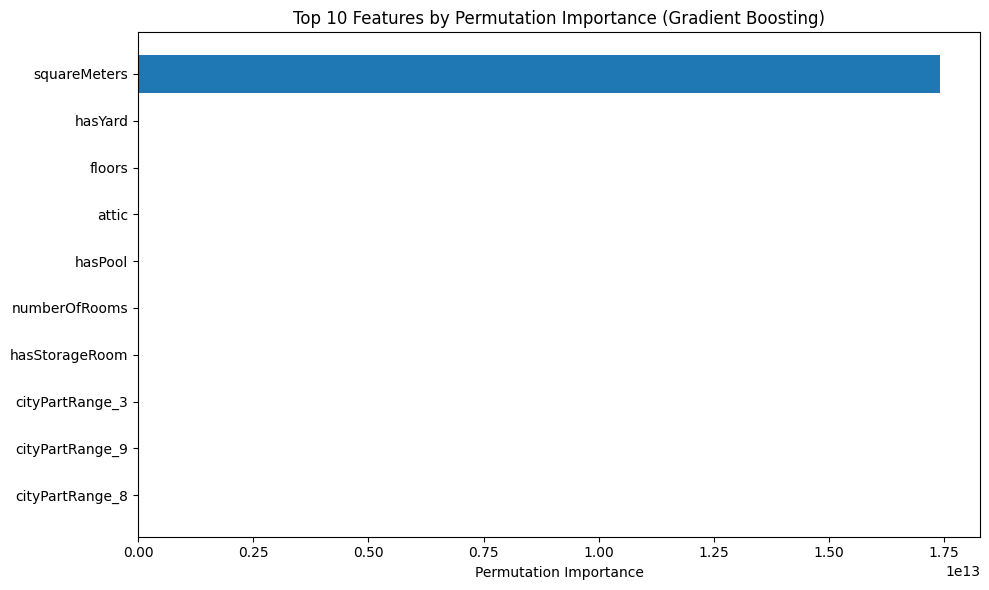

In [35]:
# Calculate permutation importance for gradient boosting regressor model
gb_model.fit(X_train, y_train)

perm_importance_gb = permutation_importance(
    gb_model, 
    X_test,  # Use test set for unbiased importance
    y_test, 
    n_repeats=10,  # Number of times to permute each feature
    random_state=42,
    scoring='neg_mean_squared_error'  # Use 'neg_mean_squared_error' for regression
)

# Get feature names (assuming X_train is a DataFrame)
feature_names_gb = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]    

# Create a DataFrame with results
importance_df_gb = pd.DataFrame({
    'feature': feature_names_gb,
    'importance_mean': perm_importance_gb.importances_mean, # type: ignore
    'importance_std': perm_importance_gb.importances_std # type: ignore
})

# Sort by importance and get top 10
top_10_features_gb = importance_df_gb.sort_values('importance_mean', ascending=False).head(10)  
print("Top 10 Features by Permutation Importance (Gradient Boosting):")
print(top_10_features_gb)

# Plot the results for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.barh(range(10), top_10_features_gb['importance_mean'][::-1])
plt.yticks(range(10), top_10_features_gb['feature'][::-1]) # type: ignore
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features by Permutation Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

And with the gradient boosting regressor model, the top 3 are common between all three models:

- `squareMeters`
- `floors`
- `hasYard`

Putting all the results together, it appears that the size of the property in square meters along with the number of floors and whether it has a yard or a pool are the most important features that influence the property prices in this dataset.

The location of the property, represented by `cityPartRange`, also plays a significant role in determining the price, but it is not as significant as the size and features of the property itself.

### Feature Importance using SHAP Values

Let us now analyze the feature importance using SHAP values. SHAP values provide a unified measure of feature importance and can help us understand the contribution of each feature to the model's predictions.

#### SHAP Values for Linear Regression Model

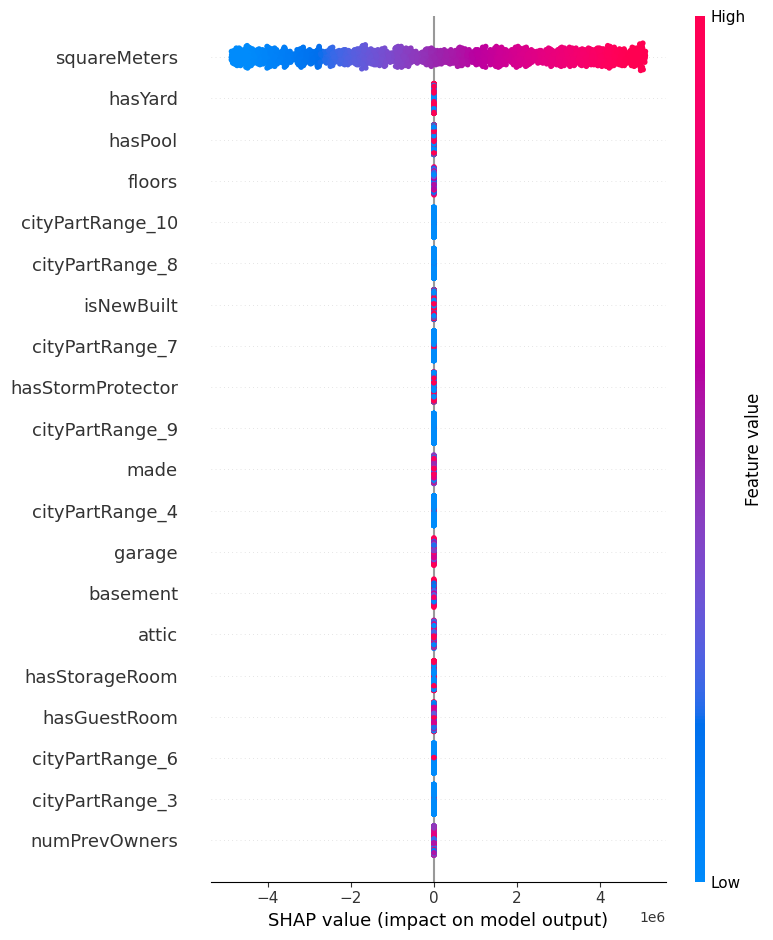

In [36]:
# SHAP explainer expects numerical data. Convert category columns to their codes.
X_train_shap = X_train.copy()
X_test_shap = X_test.copy()

for col in X_train_shap.select_dtypes(include='category').columns:
	X_train_shap[col] = X_train_shap[col].cat.codes
	X_test_shap[col] = X_test_shap[col].cat.codes

# Convert boolean columns to integers
for col in X_train_shap.select_dtypes(include='bool').columns:
	X_train_shap[col] = X_train_shap[col].astype(int)
	X_test_shap[col] = X_test_shap[col].astype(int)

# Create SHAP explainer
explainer = shap.Explainer(linear_model, X_train_shap)

# Calculate SHAP values
shap_values = explainer(X_test_shap)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_shap)

The SHAP values order seem to be same for the first 5 features as the feature importance from the Linear Regression model.

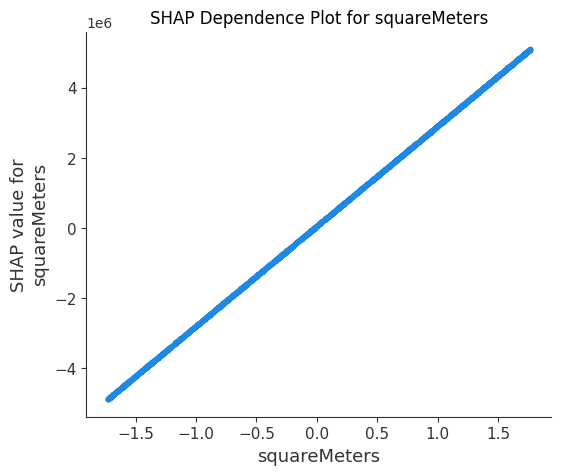

In [37]:
# SHAP dependence plot for squareMeters
shap.dependence_plot('squareMeters', shap_values.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for squareMeters')
plt.show()

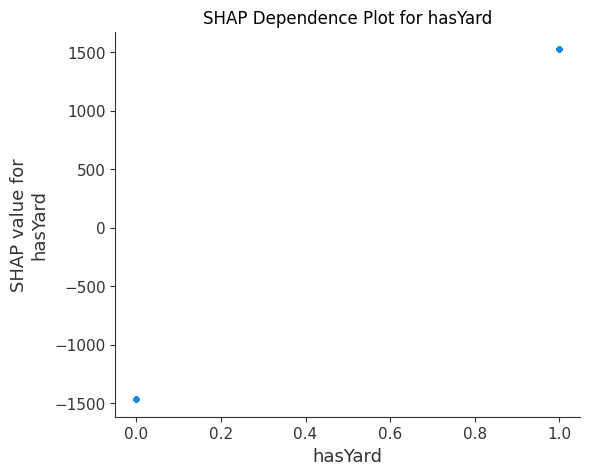

In [38]:
# SHAP Dependence plot for hasYard
shap.dependence_plot('hasYard', shap_values.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for hasYard')
plt.show()

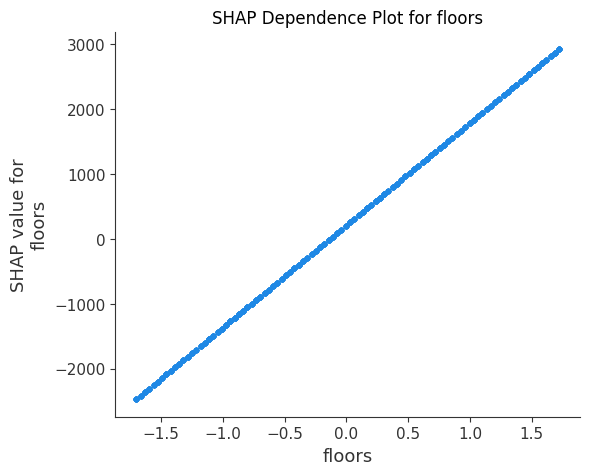

In [39]:
# SHAP Dependence plot for floors
shap.dependence_plot('floors', shap_values.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for floors')
plt.show()

**Analysis of SHAP Dependence Plots:**

- Strong positive impact of `squareMeters` on price, as expected
- `floors` too shows a clear positive relationship with price, indicating that more floors generally lead to higher prices, but the strength is lower
- `hasYard` shows a clear positive relationship with price, indicating that properties with yards tend to have higher prices

We only analyzed three of top 5 features, in order to compare with the SHAP values from Random Forest Regressor model.

Since `hasPool` is also binary in nature, we omitted it from dependency plot analysis, as it would show similar results to `hasYard`.

#### SHAP Values for Random Forest Regressor Model

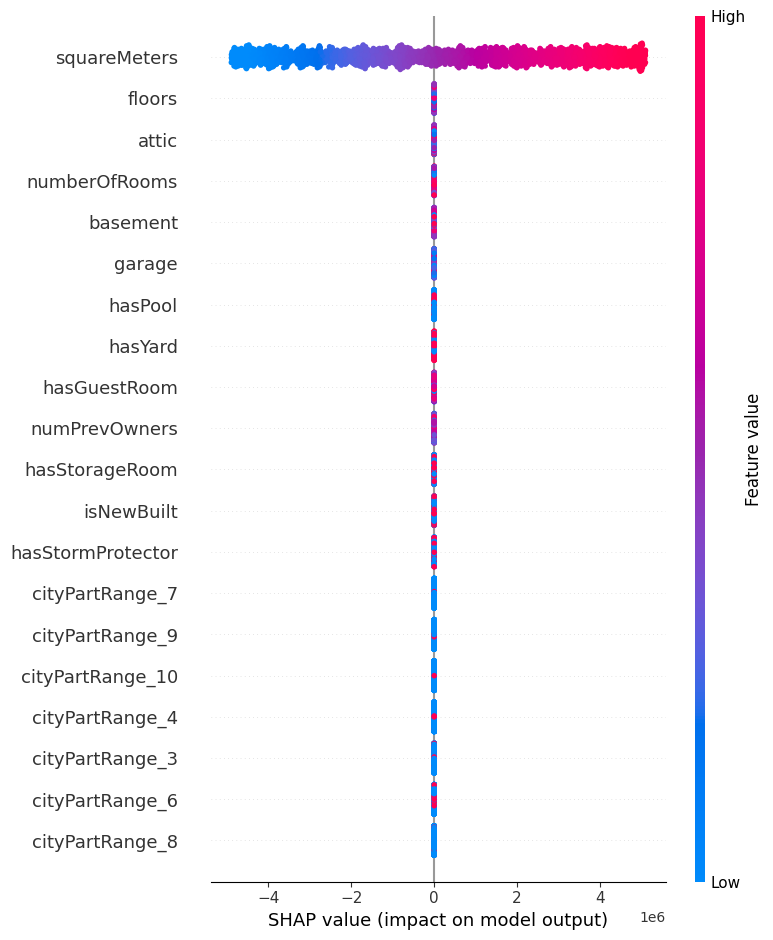

In [40]:
# SHAP with Random Forest Regressor
explainer_rf = shap.Explainer(rf_model, X_train_shap)
shap_values_rf = explainer_rf(X_test_shap)

# Plot SHAP values for Random Forest Regressor
shap.summary_plot(shap_values_rf, X_test_shap)

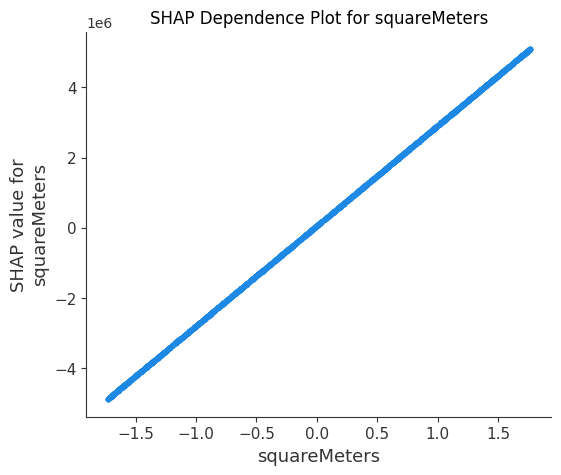

In [41]:
# SHAP dependence plot for squareMeters
shap.dependence_plot('squareMeters', shap_values_rf.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for squareMeters')
plt.show()

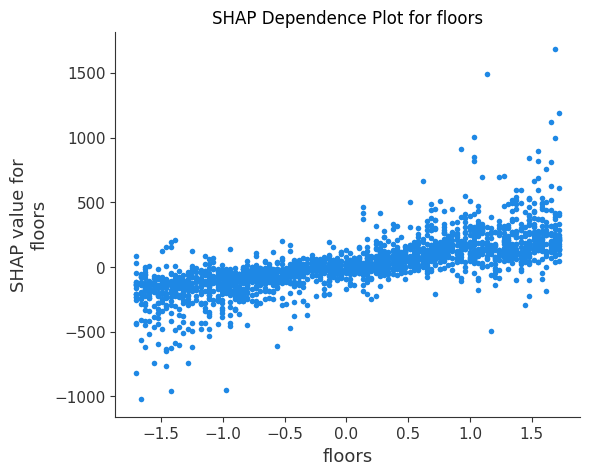

In [42]:
# SHAP dependence plot for floors
shap.dependence_plot('floors', shap_values_rf.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for floors')
plt.show()

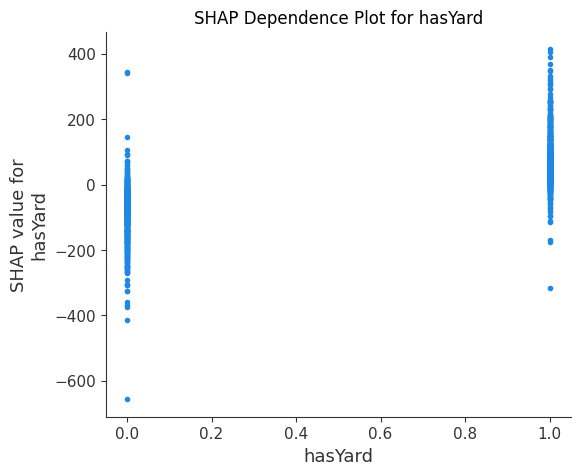

In [43]:
# SHAP dependence for hasYard
shap.dependence_plot('hasYard', shap_values_rf.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for hasYard')
plt.show()

**Analysis of SHAP Dependence Plots:**

- Strong positive impact of `squareMeters` on price, as expected
- The impact of `floors` is also positive, but since the Random Forest is a non-linear model, the relationship is not as clear as in the Linear Regression model.
- And `hasYard` while showing a postive relationship, it does have significant noise in the SHAP values, indicating that the model is not able to explain the relationship between `hasYard` and `price` as well as it does for `squareMeters` and `floors`.

### SHAP Values for Gradient Boosting Regressor Model

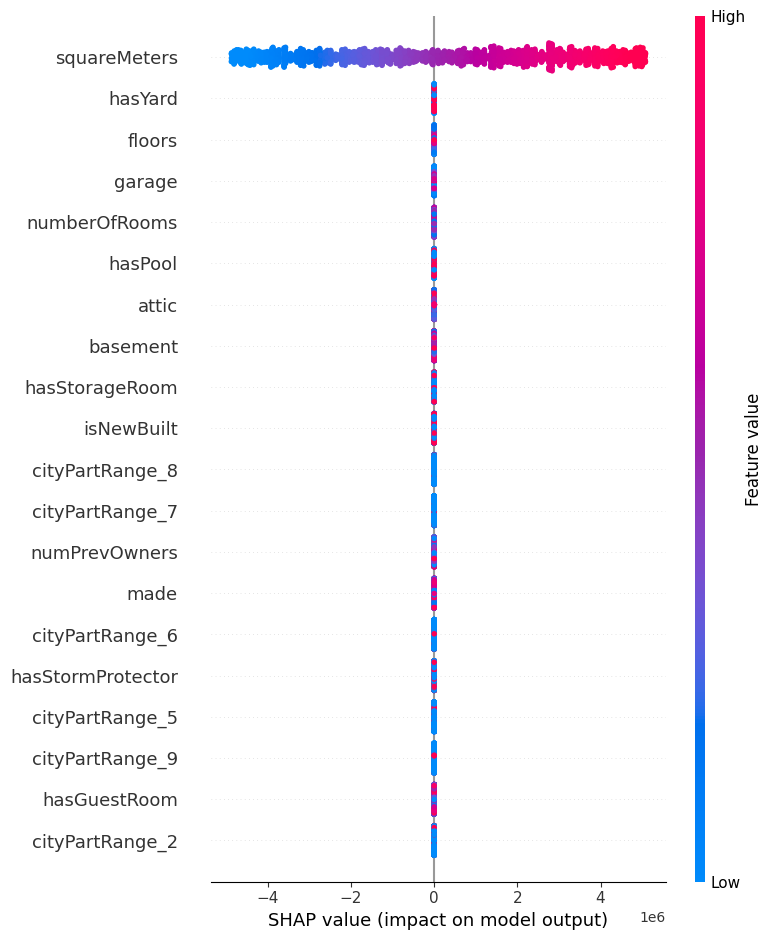

In [44]:
# SHAP values for Gradient Boosting Regressor Model
explainer_gb = shap.Explainer(gb_model, X_train_shap)
shap_values_gb = explainer_gb(X_test_shap)  

# SHAP values for Gradient Boosting Regressor Model
shap.summary_plot(shap_values_gb, X_test_shap)  

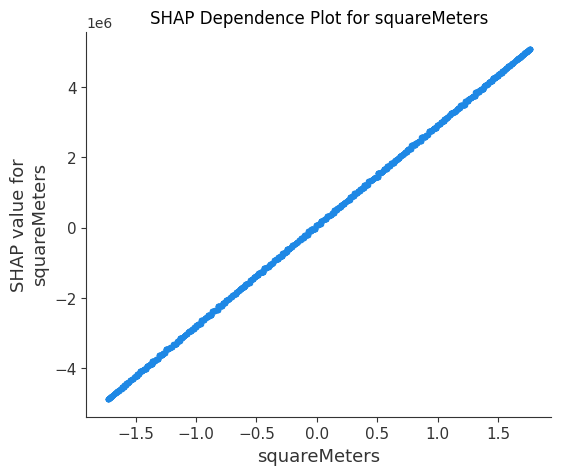

In [45]:
# shap dependence plot for squareMeters
shap.dependence_plot('squareMeters', shap_values_gb.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for squareMeters')
plt.show()

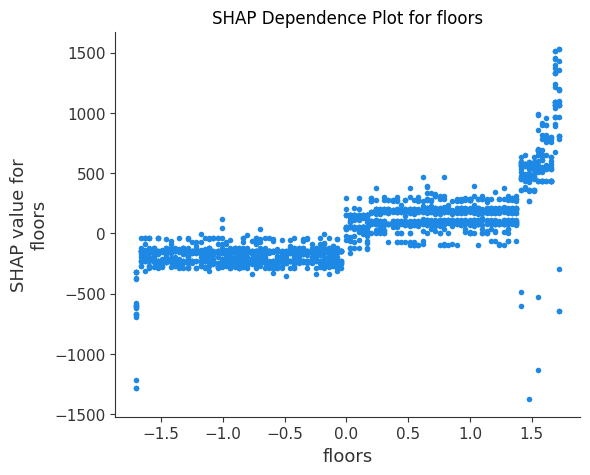

In [46]:
# SHAP dependence plot for floors
shap.dependence_plot('floors', shap_values_gb.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for floors')
plt.show()

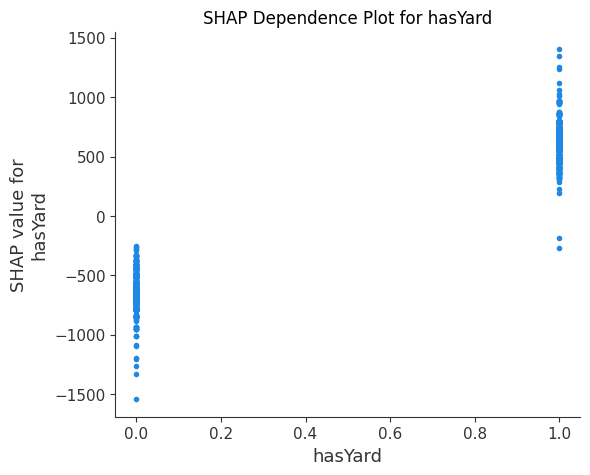

In [47]:
# SHAP dependence plot for hasYard
shap.dependence_plot('hasYard', shap_values_gb.values, X_test_shap,
                     interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for hasYard')
plt.show()

**Analysis of SHAP Dependence Plots:**

- Strong positive impact of `squareMeters` on price, as expected
- `floors` has a positive impact, but less pronounced than `squareMeters`. There is some kind of steps noticed in the SHAP values, indicating that if the number of floors is higher than the mean floors, the price increases significantly.
- `hasYard` has a slightly better relationship with price with Gradient Boosting Regressor model compared to Random Forest model, as noticed from lesser overlap of the SHAP values.

## Final Model Selection

We shall use the Linear Regression model as the final model for this task, as it is the simplest model that is able to explain 100% of the variance in the target variable `price`.

As we saw earlier, top 5 features of the linear regression model are more than sufficient to explain the variance in the target variable `price`, and the model is able to predict the price of the properties with a very high accuracy.

The top 5 features are:
- `squareMeters`
- `floors`
- `hasYard`
- `hasPool`
- `cityPartRange_10`

In [48]:
# select the top 5 features from the original dataset
top_5_features = ['squareMeters', 'floors', 'hasYard', 'hasPool', 'cityPartRange']

paris_real_estate_top5 = paris_real_estate_processing[top_5_features + ['price']]

# split the top 5 features dataset into train and test sets
X_train_top5, X_test_top5, y_train_top5, y_test_top5 = train_test_split(
    paris_real_estate_top5.drop(columns=['price']),
    paris_real_estate_top5['price'],
    test_size=0.2,
    random_state=42
)

# transform cityPartRange to 0 or 1 based on the if the cityPartRange is 10 or not
X_train_top5['cityPartRange_10'] = (X_train_top5['cityPartRange'] == 10).astype(int)
X_test_top5['cityPartRange_10'] = (X_test_top5['cityPartRange'] == 10).astype(int)

# drop the original cityPartRange column
X_train_top5 = X_train_top5.drop(columns=['cityPartRange'])
X_test_top5 = X_test_top5.drop(columns=['cityPartRange'])

# print the shape of the top 5 features train and test sets
print(f"\nShape of the training set with top 5 features: {X_train_top5.shape}")
print(f"Shape of the testing set with top 5 features: {X_test_top5.shape}")

# save the processed top 5 features train and test sets to CSV files
X_train_top5.to_csv('X_train_top5_processed.csv', index=False)
X_test_top5.to_csv('X_test_top5_processed.csv', index=False)
y_train_top5.to_csv('y_train_top5_processed.csv', index=False)
y_test_top5.to_csv('y_test_top5_processed.csv', index=False)


Shape of the training set with top 5 features: (8000, 5)
Shape of the testing set with top 5 features: (2000, 5)


Lets us SKLearn pipelines to create a final model that can be used to predict the price of the properties based on these features.

This way, all the steps are streamlined and can be easily reproduced or modified in the future.

In [49]:
# create a pipeline with a column transformer and a linear regression model
pipeline_top5 = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['squareMeters', 'floors']),
            ('cat', 'passthrough', ['hasYard', 'hasPool', 'cityPartRange_10'])
        ])),
    ('model', LinearRegression())
])

# fit the pipeline to the training data
pipeline_top5.fit(X_train_top5, y_train_top5)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [50]:
# evaluate the model on the test set
y_pred_top5 = pipeline_top5.predict(X_test_top5)
mse_top5 = mean_squared_error(y_test_top5, y_pred_top5)
rmse_top5 = mse_top5 ** 0.5
r2_top5 = r2_score(y_test_top5, y_pred_top5)    

# print the evaluation metrics
print(f"\nEvaluation Metrics for Linear Regression Model with Top 5 Features:")
print(f"Mean Squared Error (MSE): {mse_top5:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_top5:.2f}")
print(f"R-squared (R^2): {r2_top5:.2f}")    


Evaluation Metrics for Linear Regression Model with Top 5 Features:
Mean Squared Error (MSE): 3724382.62
Root Mean Squared Error (RMSE): 1929.87
R-squared (R^2): 1.00


In [51]:
# print the coefficients of the linear regression model with tabulate
linear_model_top5 = pipeline_top5.named_steps['model']
coefficients_top5 = pd.Series(linear_model_top5.coef_, index=X_train_top5.columns).sort_values(ascending=False)
print("\nCoefficients of Linear Regression Model with Top 5 Features:")
print(tabulate(coefficients_top5.reset_index(), headers=['Feature', 'Coefficient'], tablefmt='grid'))


Coefficients of Linear Regression Model with Top 5 Features:
+----+------------------+----------------+
|    | Feature          |    Coefficient |
+====+==================+================+
|  0 | squareMeters     |    2.85562e+06 |
+----+------------------+----------------+
|  1 | hasPool          | 2998.56        |
+----+------------------+----------------+
|  2 | hasYard          | 2995.95        |
+----+------------------+----------------+
|  3 | floors           | 1575.32        |
+----+------------------+----------------+
|  4 | cityPartRange_10 |  294.207       |
+----+------------------+----------------+


In [52]:
# take a sample property to predict the price
# this is very close to the second sample in the original dataset
sample_square_meters = 78000 
sample_floors = 80  
sample_has_yard = 0  
sample_has_pool = 0  
sample_city_part_range = 8 

In [53]:
# create a function to predict the price of the property
def predict_price_top5(square_meters, floors, has_yard, has_pool, city_part_range):
    # create a DataFrame with the sample property
    sample_property = pd.DataFrame({
        'squareMeters': [square_meters],
        'floors': [floors],
        'hasYard': [has_yard],
        'hasPool': [has_pool],
        'cityPartRange_10': [1 if city_part_range == 10 else 0]
    })

    print(sample_property)
    
    # predict the price using the pipeline
    predicted_price = pipeline_top5.predict(sample_property)
    
    return predicted_price[0]

In [54]:
# predict the price of the property for the sample
predicted_price = predict_price_top5(sample_square_meters, sample_floors, sample_has_yard, sample_has_pool, sample_city_part_range)
print(f"\nPredicted price for the property is: {predicted_price:.2f}")

   squareMeters  floors  hasYard  hasPool  cityPartRange_10
0         78000      80        0        0                 0

Predicted price for the property is: 7805006.24


In [55]:
# print all the values of the second sample in the training set
second_sample = X_train_top5.iloc[1]
print("\nSecond sample in the training set:")
print(tabulate(second_sample.reset_index(), headers=['Feature', 'Value'], tablefmt='grid'))

# actual price of the second sample in the training set
actual_price_second_sample = y_train_top5.iloc[1]
print(f"\nActual price of the second sample in the training set: {actual_price_second_sample:.2f}")


Second sample in the training set:
+----+------------------+---------+
|    | Feature          |   Value |
+====+==================+=========+
|  0 | squareMeters     |   78731 |
+----+------------------+---------+
|  1 | floors           |      79 |
+----+------------------+---------+
|  2 | hasYard          |       0 |
+----+------------------+---------+
|  3 | hasPool          |       0 |
+----+------------------+---------+
|  4 | cityPartRange_10 |       0 |
+----+------------------+---------+

Actual price of the second sample in the training set: 7878473.10


Let us now save this pipeline to a file so that it can be used later to predict the price of the properties based on the features.

In [56]:
# save the trained pipeline to a file
joblib.dump(pipeline_top5, 'paris_real_estate_pipeline_top5.pkl')

['paris_real_estate_pipeline_top5.pkl']